# Analyse Water Scarcity from ISIMIP2b
Main script to analyse the processed water scarcity from ISIMIP2b


/rhea/scratch/brussel/vo/000/bvo00012/vsc10055/waterscarcity/waterscarcity_isimip/init.py:186: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  d_time_ncfile = {'historical': pd.date_range(start='1861-01-01', end='2006-01-01', freq='M'),
/rhea/scratch/brussel/vo/000/bvo00012/vsc10055/waterscarcity/waterscarcity_isimip/init.py:187: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  'rcp26': pd.date_range(start='2006-01-01', end='2100-01-01', freq='M'),
/rhea/scratch/brussel/vo/000/bvo00012/vsc10055/waterscarcity/waterscarcity_isimip/init.py:188: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  'rcp60':pd.date_range(start='2006-01-01', end='2100-01-01', freq='M') }
/rhea/scratch/brussel/vo/000/bvo00012/vsc10055/waterscarcity/waterscarcity_isimip/init.py:190: FutureWarning: 'Y' is deprecated and will be removed in a future version, pleas

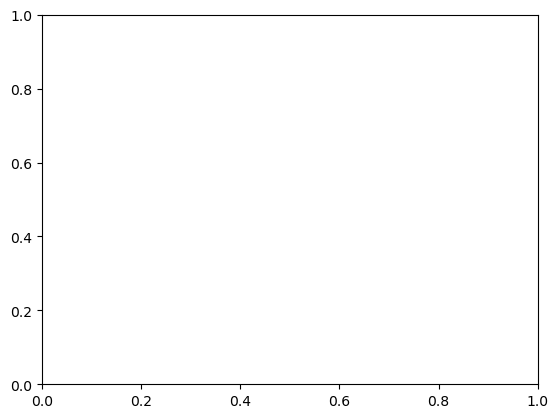

In [1]:
# import modules
import os
import xarray as xr
import matplotlib.pyplot as plt
from init import *
from functions import *
import pandas as pd
import cartopy.crs as ccrs

# to show plots in the notebook
%matplotlib inline 
set_plot_param()
import matplotlib as mpl


map_proj = ccrs.Robinson(central_longitude=0, globe=None)

scenario_text = {'rcp26': 'RCP 2.6','rcp60':'RCP 6.0'}

# define ISIMIP models, forcings and variables

models    =  [ 'LPJmL','CWatM','MATSIRO', 'H08']
forcings  = ['gfdl-esm2m', 'ipsl-cm5a-lr', 'hadgem2-es', 'miroc5']

In [2]:
# Load data

#da_flowdir = xr.open_dataarray(routingdir +'ddm30_flowdir_cru_neva.nc')
da_basins  = xr.open_dataarray(routingdir +'ddm30_basins_cru_neva.nc')
#da_slopes  = xr.open_dataarray(routingdir +'ddm30_slopes_cru_neva.nc')

# load cell area
da_cellarea = xr.open_dataarray(outdir +'upstream_calc/cellarea.nc')
secs_in_year=31536000 

# load land mask
landmask = da_basins>0
landmask['names'] = 'Global' # assing name, for plotting purpose

# preprocess basins
save_basinfile()


# create mask for medditerean 
regions_mask = create_regionsmask(landmask)
med_mask = regions_mask.sel(region=19)

# load monthly population
fn_pop = 'corrected_population_histsoc_rcp26soc_0p5deg_annual_1861-2100.nc4'

# new population (only rcp26 based) 
pop = load_pop(fn_pop)
    
# for plotting
GMT_offset=0.1
GMT_levels = [1, 2, 3]

/rhea/scratch/brussel/vo/000/bvo00012/vsc10055/waterscarcity/waterscarcity_isimip/functions.py:1581: RuntimeWarning: invalid value encountered in cast
  basin = basin.astype(np.int64)


# Diagnostics

## Water availability difference maps

### RCP 2.6

In [3]:
def get_qavail_year(year_range, landmask, models, scenarios, forcings):

    variable = 'q_avail'
    scenario_list = []
    for scenario in scenarios: # don't include historical

        # loop over models
        model_list = []
        for model in models:  
            forcing_list = []

            for forcing in forcings: 

                map_list = []


                var_dir = outdir+'intermediate/'
                da_var = variable
                socscen = True


                filedir, filename = get_simulation_name_dir(variable, var_dir, model, forcing, scenario, 'annual', socscen=False)
                filedir_hist, filename_hist = get_simulation_name_dir(variable, var_dir, model, forcing, 'historical', 'annual', socscen=False)

                if filename!='false': 
                    # save to output location
                    ds_wateravail = xr.open_dataset(filedir+filename, engine='netcdf4')
                    # select years to calculate average from corresponding to GMT average

                    year_mask = ds_wateravail['time'].dt.year.isin(year_range) 

                    da_map = ds_wateravail['q_avail'].where(year_mask).where(landmask).mean('time')

                else: 
                    if scenario == 'historical': 
                        empty_array = np.empty_like(map_list[0].values)

                    else: 
                        empty_array = np.empty_like(map_list[1].values)

                    empty_array[:] = np.nan    
                    da_map = xr.DataArray(empty_array, dims=('time'))

                forcing_list.append(da_map)    

            ds_model = xr.concat(forcing_list, dim='forcing').mean('forcing')

            model_list.append(ds_model)

        ds_scenario = xr.concat(model_list, dim='model').mean('model')
        scenario_list.append(ds_scenario)


    da_map_full  =xr.concat(scenario_list, dim='scenario').assign_coords({'scenario':scenarios})

    return da_map_full

def get_qavail_historical(year_range, landmask, models, scenarios, forcings):

    variable = 'q_avail'
    scenario_list = []
    for scenario in scenarios: 
        # loop over models
        model_list = []
        for model in models:  
            forcing_list = []

            for forcing in forcings: 

                map_list = []


                var_dir = outdir+'intermediate/'
                da_var = variable
                socscen = True


                filedir, filename = get_simulation_name_dir(variable, var_dir, model, forcing, scenario, 'annual', socscen=False)
                filedir_hist, filename_hist = get_simulation_name_dir(variable, var_dir, model, forcing, 'historical', 'annual', socscen=False)

                if filename!='false': 
                    # save to output location
                    ds_wateravail = xr.open_dataset(filedir_hist+filename_hist, engine='netcdf4')

                    year_mask = ds_wateravail['time'].dt.year.isin(year_range) 

                    da_map = ds_wateravail['q_avail'].where(year_mask).where(landmask).mean('time')
                else: 
                    print('file not present')
                    if scenario == 'historical': 
                        empty_array = np.empty_like(map_list[0].values)

                    else: 
                        empty_array = np.empty_like(map_list[1].values)

                    empty_array[:] = np.nan    
                    da_map = xr.DataArray(empty_array, dims=('time'))

                forcing_list.append(da_map)    

            ds_model = xr.concat(forcing_list, dim='forcing').mean('forcing')

            model_list.append(ds_model)

        ds_scenario = xr.concat(model_list, dim='model').mean('model')
        scenario_list.append(ds_scenario)


    da_map_full  =xr.concat(scenario_list, dim='scenario').assign_coords({'scenario':scenarios})
    return da_map_full


def calc_exposure_map(sel_scenario, year_range_fut, year_range_hist, landmask, models, scenarios, forcings, flag_intermediate=False, flag_perbasin=False, flag_relative = False): 
# calculate exposure map for 0° GMT warming
    print('calculating ref')

    # calculate reference value
    da_map_ref = get_qavail_historical(year_range_hist,  landmask, models, ['historical'], forcings)


    # calculate exposure map for 0° GMT warming
    print('calculating fut')
    da_map_fut =  get_qavail_year(year_range_fut, landmask, models, scenarios[1:], forcings)


    # calculate difference and multi-model mean
    delta_map = da_map_fut - da_map_ref.squeeze()

    if flag_relative: 
        delta_map = delta_map/da_map_ref.squeeze() *100

    if flag_perbasin: 
        delta_mmm = calc_mean_perbasin(delta_map.sel({'scenario':sel_scenario}), landmask)
    else: 
        delta_mmm = delta_map.sel({'scenario':sel_scenario})

    return delta_mmm


In [4]:
def get_demand_year(year_range, landmask, models, scenarios, forcings):

    variable = 'ptotww'
    scenario_list = []
    for scenario in scenarios: # don't include historical

        # loop over models
        model_list = []
        for model in models:  
            forcing_list = []

            for forcing in forcings: 

                map_list = []


                var_dir = outdir+'intermediate/'
                da_var = variable
                socscen = True


                filedir, filename = get_simulation_name_dir(variable, var_dir, model, forcing, scenario, 'annual', socscen=False)
                filedir_hist, filename_hist = get_simulation_name_dir(variable, var_dir, model, forcing, 'historical', 'annual', socscen=False)
                filedir_qavail, filename_qavail = get_simulation_name_dir('q_avail', var_dir, model, forcing, scenario, 'annual', socscen=False)

                if filename!='false': 
                    # save to output location
                    ds_wateravail = xr.open_dataset(filedir+filename, engine='netcdf4', decode_times=False)
                    # select years to calculate average from corresponding to GMT average
                    da_time = xr.open_dataset(filedir_qavail+ filename_qavail , engine='netcdf4')['time']
                    ds_wateravail['time'] = da_time.values
                    year_mask = ds_wateravail['time'].dt.year.isin(year_range) 

                    da_map = ds_wateravail[variable].where(year_mask).where(landmask).mean('time')

                else: 
                    if scenario == 'historical': 
                        empty_array = np.empty_like(map_list[0].values)

                    else: 
                        empty_array = np.empty_like(map_list[1].values)

                    empty_array[:] = np.nan    
                    da_map = xr.DataArray(empty_array, dims=('time'))

                forcing_list.append(da_map)    

            ds_model = xr.concat(forcing_list, dim='forcing').mean('forcing')

            model_list.append(ds_model)

        ds_scenario = xr.concat(model_list, dim='model').mean('model')
        scenario_list.append(ds_scenario)


    da_map_full  =xr.concat(scenario_list, dim='scenario').assign_coords({'scenario':scenarios})

    return da_map_full


def get_demand_preindustrial( landmask, models, scenarios, forcings):

    variable = 'ptotww'
    scenario_list = []
    for scenario in scenarios: 
        # loop over models
        model_list = []
        for model in models:  
            forcing_list = []

            for forcing in forcings: 

                map_list = []


                var_dir = outdir+'intermediate/'
                da_var = variable
                socscen = True


                filedir, filename = get_simulation_name_dir(variable, var_dir, model, forcing, scenario, 'annual', socscen=False)
                filedir_hist, filename_hist = get_simulation_name_dir(variable, var_dir, model, forcing, 'historical', 'annual', socscen=False)
                filedir_qavail, filename_qavail = get_simulation_name_dir('q_avail', var_dir, model, forcing, scenario, 'annual', socscen=False)

                if filename!='false': 
                    # save to output location
                    ds_wateravail = xr.open_dataset(filedir_hist+filename_hist, engine='netcdf4', decode_times=False)
                    da_time = xr.open_dataset(filedir_qavail+ filename_qavail , engine='netcdf4')['time']

                    ds_wateravail['time'] = da_time.values
                    year_mask = ds_wateravail['time'].dt.year.isin(range(1850,1900)) 

                    da_map = ds_wateravail[variable].where(year_mask).where(landmask).mean('time')
                else: 
                    print('file not present')
                    if scenario == 'historical': 
                        empty_array = np.empty_like(map_list[0].values)

                    else: 
                        empty_array = np.empty_like(map_list[1].values)

                    empty_array[:] = np.nan    
                    da_map = xr.DataArray(empty_array, dims=('time'))

                forcing_list.append(da_map)    

            ds_model = xr.concat(forcing_list, dim='forcing').mean('forcing')

            model_list.append(ds_model)

        ds_scenario = xr.concat(model_list, dim='model').mean('model')
        scenario_list.append(ds_scenario)


    da_map_full  =xr.concat(scenario_list, dim='scenario').assign_coords({'scenario':scenarios})
    return da_map_full

In [5]:
def get_deficit(year_range, landmask, models, scenarios, forcings):

    variable = 'ptotww'
    scenario_list = []
    for scenario in scenarios: # don't include historical

        # loop over models
        model_list = []
        for model in models:  
            forcing_list = []

            for forcing in forcings: 

                map_list = []


                var_dir = outdir+'intermediate/'
                da_var = variable
                socscen = True

                filedir, filename = get_simulation_name_dir('ptotww', var_dir, model, forcing, scenario, 'monthly', socscen=False)
                filedir_qavail, filename_qavail = get_simulation_name_dir('q_avail', var_dir, model, forcing, scenario, 'monthly', socscen=False)

                if filename!='false': 
                    # save to output location
                    ds_demand = xr.open_dataset(filedir+filename, engine='netcdf4', decode_times=False)
            
                    # select years to calculate average from corresponding to GMT average
                    ds_avail = xr.open_dataset(filedir_qavail+ filename_qavail , engine='netcdf4')
                    ds_demand['time'] = d_time_ncfile[scenario]
                    ds_avail['time'] = d_time_ncfile[scenario]  
                    
                    year_mask = ds_avail['time'].dt.year.isin(year_range) 

                    da_avail = ds_avail['q_avail'].where(year_mask, drop=True).where(landmask)
                    da_demand = ds_demand['ptotww'].where(year_mask, drop=True).where(landmask)
                    
                    da_deficit = (da_demand - da_avail).where(da_demand>da_avail).groupby('time.year').sum().mean('year')


                else: 
                    if scenario == 'historical': 
                        empty_array = np.empty_like(map_list[0].values)

                    else: 
                        empty_array = np.empty_like(map_list[1].values)

                    empty_array[:] = np.nan    
                    da_map = xr.DataArray(empty_array, dims=('time'))

                forcing_list.append(da_deficit)    

            ds_model = xr.concat(forcing_list, dim='forcing').mean('forcing')

            model_list.append(ds_model)

        ds_scenario = xr.concat(model_list, dim='model').mean('model')
        scenario_list.append(ds_scenario)


    da_map_full  =  xr.concat(scenario_list, dim='scenario').assign_coords({'scenario':scenarios})

    return da_map_full

def get_deficit_historical(year_range, landmask, models, scenarios, forcings):
    variable = 'ptotww'

    scenario_list = []
    for scenario in scenarios: 
        # loop over models
        model_list = []
        for model in models:  
            forcing_list = []

            for forcing in forcings: 

                map_list = []


                var_dir = outdir+'intermediate/'
                da_var = variable
                socscen = True


                filedir, filename = get_simulation_name_dir('ptotww', var_dir, model, forcing, 'historical', 'monthly', socscen=False)
                filedir_qavail, filename_qavail = get_simulation_name_dir('q_avail', var_dir, model, forcing, scenario, 'monthly', socscen=False)

                if filename!='false': 

                    ds_demand = xr.open_dataset(filedir+filename, engine='netcdf4', decode_times=False)
            
                    # select years to calculate average from corresponding to GMT average
                    ds_avail = xr.open_dataset(filedir_qavail+ filename_qavail , engine='netcdf4')
                    ds_demand['time'] = d_time_ncfile[scenario]
                    ds_avail['time'] = d_time_ncfile[scenario]
                    year_mask = ds_avail['time'].dt.year.isin(year_range) 

                    da_avail = ds_avail['q_avail'].where(year_mask, drop=True).where(landmask)
                    da_demand = ds_demand['ptotww'].where(year_mask, drop=True).where(landmask)
                    
                    da_deficit = (da_demand - da_avail).where(da_demand>da_avail).groupby('time.year').sum().mean('year')

                else: 
                    print('file not present')
                    if scenario == 'historical': 
                        empty_array = np.empty_like(map_list[0].values)

                    else: 
                        empty_array = np.empty_like(map_list[1].values)

                    empty_array[:] = np.nan    
                    da_map = xr.DataArray(empty_array, dims=('time'))

                forcing_list.append(da_deficit)    

            ds_model = xr.concat(forcing_list, dim='forcing').mean('forcing')

            model_list.append(ds_model)

        ds_scenario = xr.concat(model_list, dim='model').mean('model')
        scenario_list.append(ds_scenario)


    da_map_full  =xr.concat(scenario_list, dim='scenario').assign_coords({'scenario':scenarios})
    return da_map_full

In [6]:
def calc_mean_perbasin(da, landmask):
    print('calculating means per basin')
    #da_basins = xr.open_dataset(outdir+'intermediate/basins.nc')['basin']
    da_basins = xr.open_dataset(outdir+'upstream_calc/basins.nc')['basin']
    
    # only keep basins with more than 10 grid cells to reduce time
    basins, basin_counts = np.unique(da_basins, return_counts=True)
    basin_numbers = basins[basin_counts>10]
    da_basin_means = []

    for number in basin_numbers: 
        mean_basin = da.where(da_basins==number).mean(dim=('lat','lon'))
        da_basin_means.append(((da_basins==number) * mean_basin.values.item()))

    da_basins_concat = xr.concat(da_basin_means, dim='basins')
    da_perbasin = da_basins_concat.sum(dim='basins').where(landmask)

    return da_perbasin


In [7]:
def calc_deficit_map(sel_scenario, year_range_fut, year_range_hist, landmask, models, scenarios, forcings, flag_intermediate=False, flag_perbasin=False, flag_relative = False): 
    # calculate exposure map for 0° GMT warming
    #year_range = range(2070,2099)

    print('calculating ref')

    # calculate reference value

    da_map_ref =  get_deficit_historical(year_range_hist, landmask, models,  ['historical'], forcings)


    # calculate exposure map for 0° GMT warming
    print('calculating fut')
    da_map_fut = get_deficit(year_range_fut, landmask, models, scenarios[1:], forcings)

    # calculate difference and multi-model mean
    delta_map = da_map_fut - da_map_ref.squeeze()

    if flag_relative: 
        delta_map = delta_map/da_map_ref.squeeze() *100

    if flag_perbasin: 
        delta_mmm = calc_mean_perbasin(delta_map.sel({'scenario':sel_scenario}), landmask)
    else: 
        delta_mmm = delta_map.sel({'scenario':sel_scenario})

    return delta_mmm

## plotting

calculating ref
calculating fut
calculating ref
calculating fut
calculating ref
calculating fut
calculating ref
calculating fut


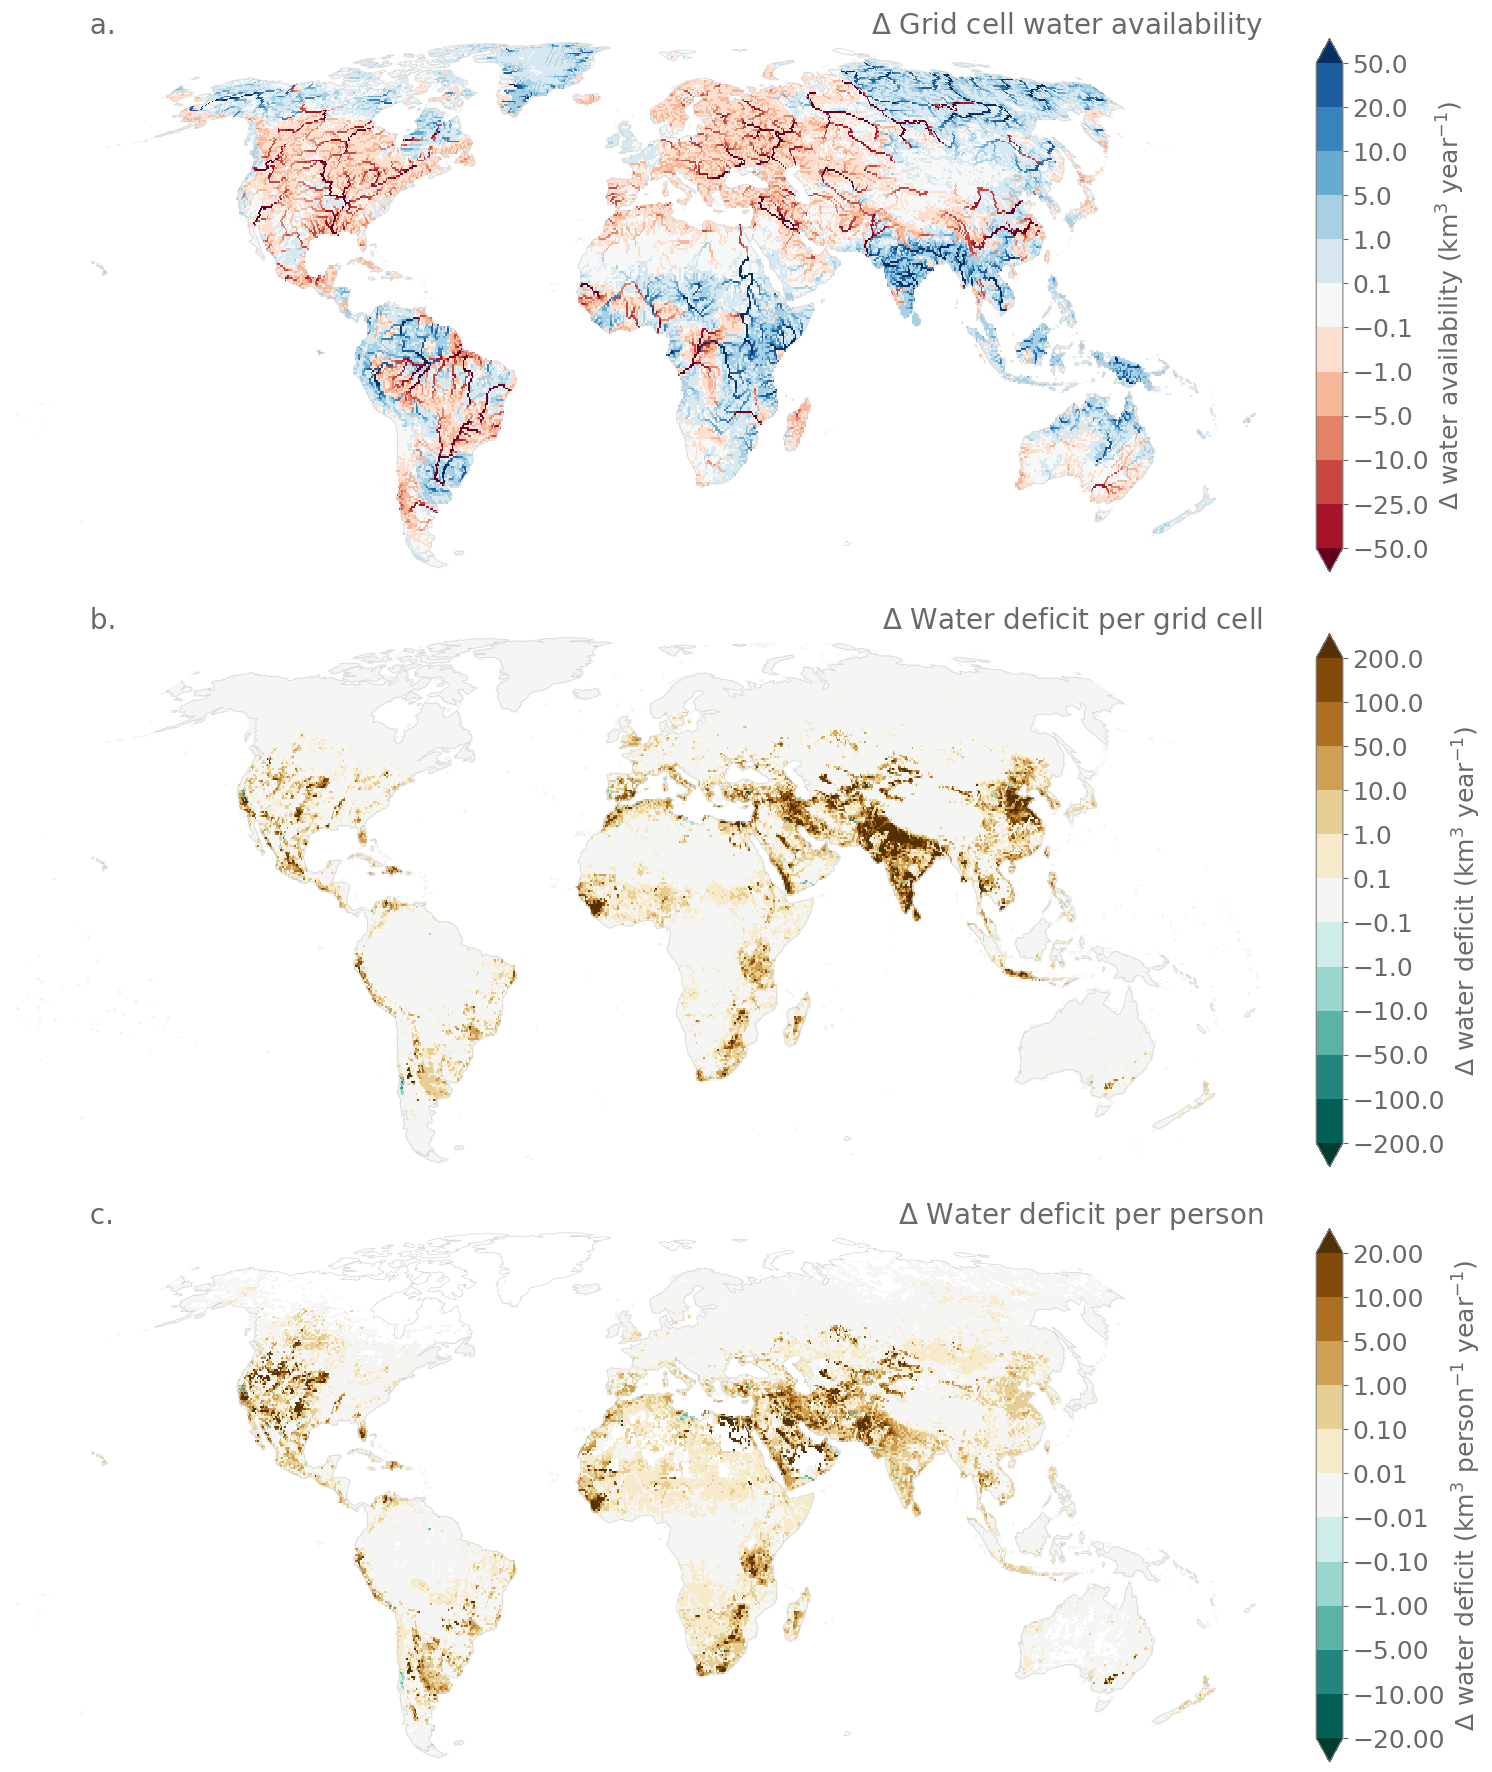

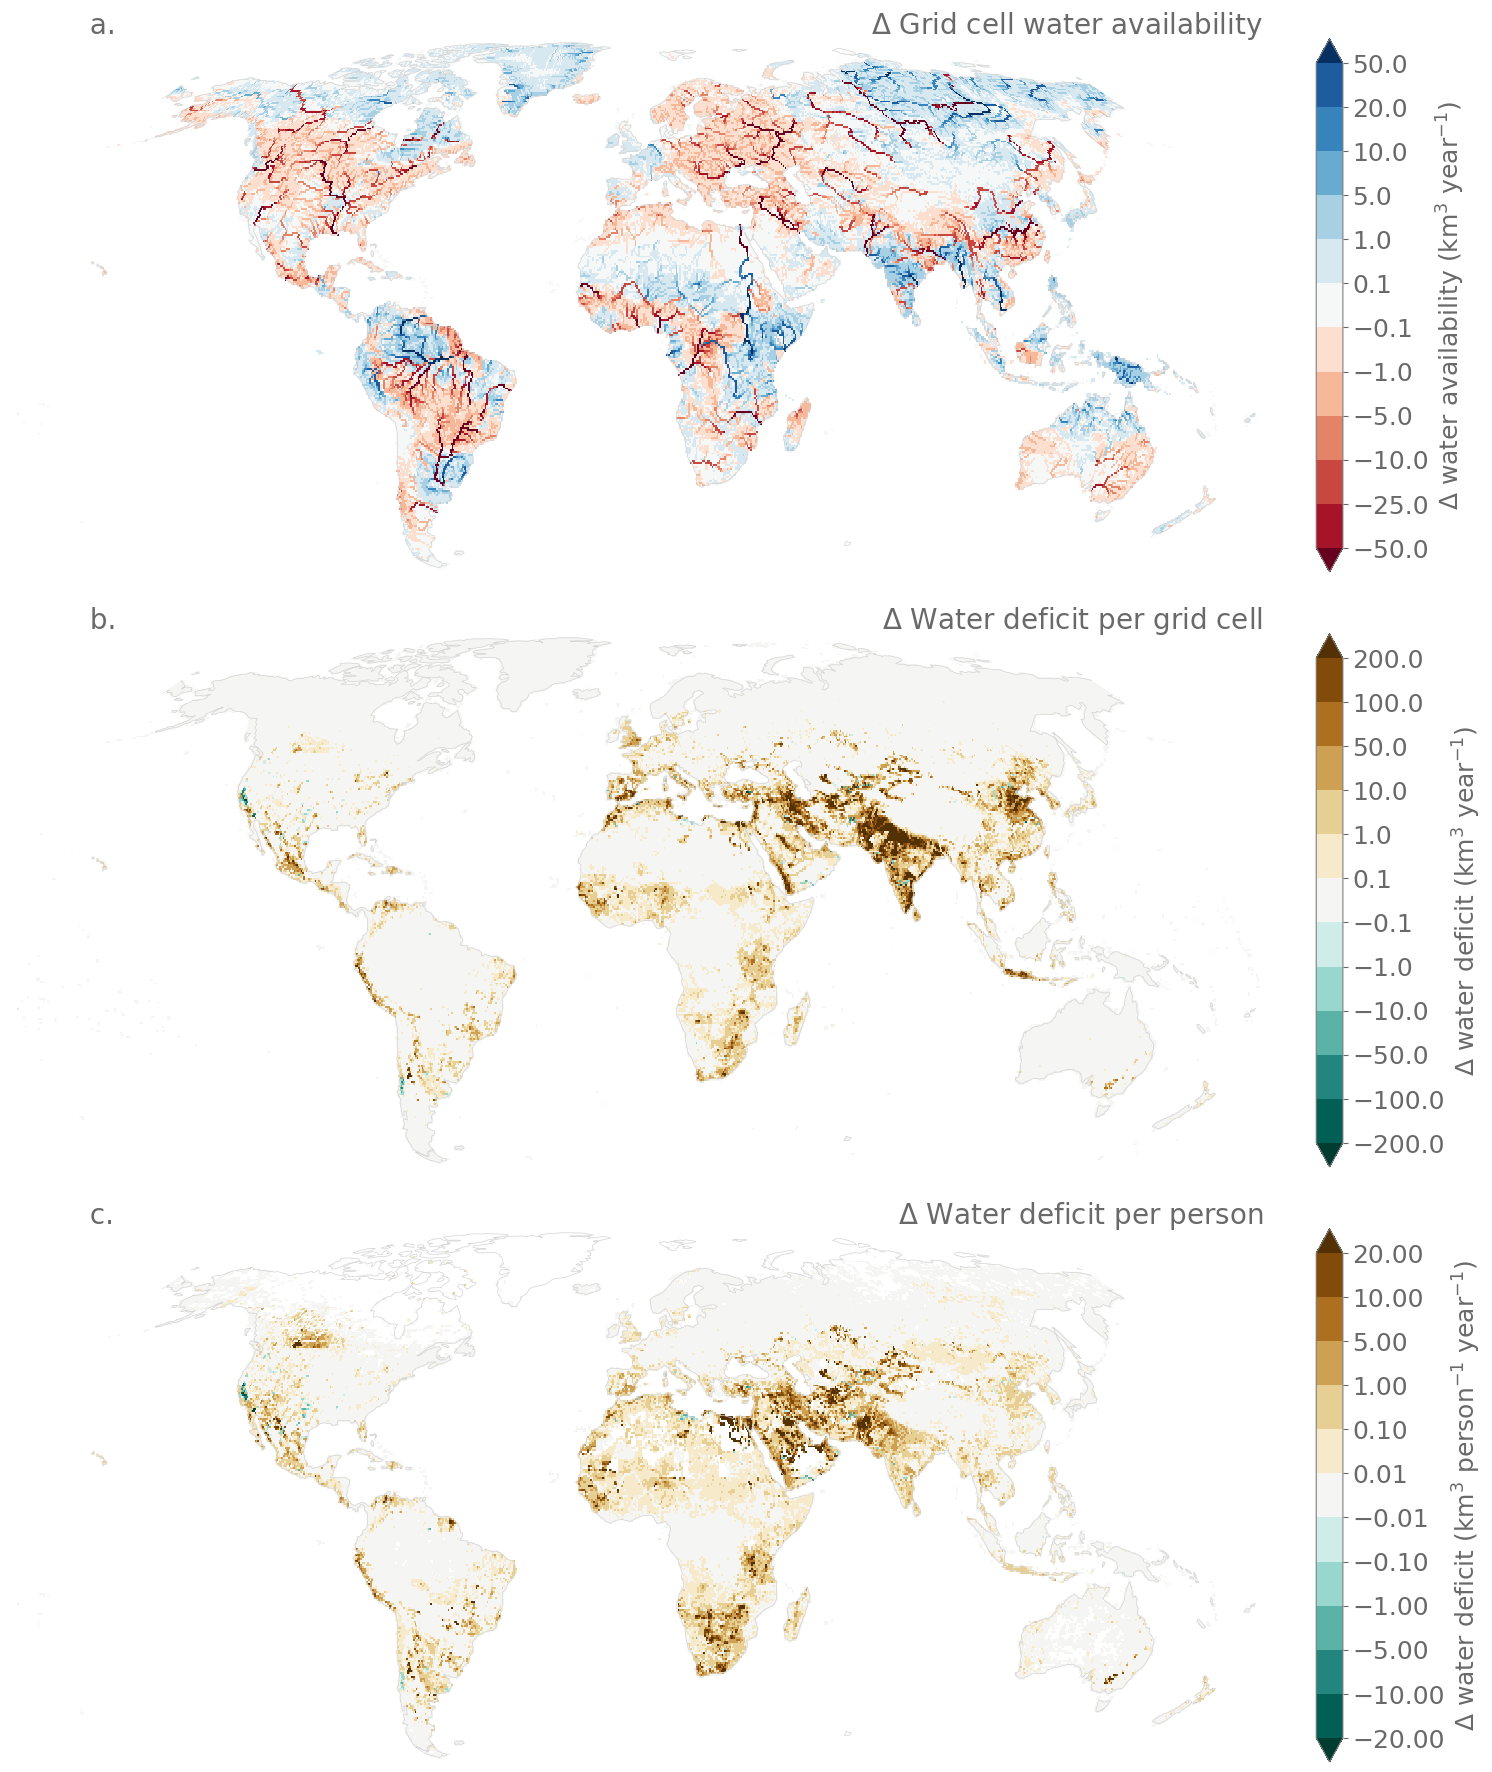

In [ ]:
rcps = ['rcp60','rcp26']

for rcp in rcps:

    year_range_fut = range(2070,2099)
    year_range_hist = range(1850,1900)

    delta_availability_rcp60 = calc_exposure_map(rcp, year_range_fut, year_range_hist, landmask, models, scenarios, forcings, flag_intermediate=False, flag_perbasin=False, flag_relative = False) *1e-8
    delta_availability_rcp60 = delta_availability_rcp60 * da_cellarea/1000  * secs_in_year

    # calculate delta's of deficit
    delta_deficit_rcp60 = calc_deficit_map(rcp,year_range_fut, year_range_hist, landmask, models, scenarios, forcings, flag_intermediate=False, flag_perbasin=False, flag_relative = False) *1e-8
    # convert from mm/m2s to m3/year
    delta_deficit_rcp60 = (delta_deficit_rcp60 * da_cellarea/1000  * secs_in_year).where(landmask)


    # deficit per person

    year_mask = pop['time'].dt.year.isin(range(1850,1900)) 

    pop_endofcentury = pop.where(year_mask).mean(dim='time')

    delta_deficit_rcp60_perperson = delta_deficit_rcp60/pop_endofcentury.where(pop_endofcentury>0) *1e4


    # plotting

    fig, axes = plt.subplots(3,1,figsize=(15,18), subplot_kw={'projection':map_proj})
    axes = axes.flatten()

    mpl.rc('xtick',labelsize=18)
    mpl.rc('ytick',labelsize=18)
    mpl.rc('axes',labelsize=18)


    # plot RCP 26
    ax= axes[0]

    ax.axis('off')
    ax.coastlines(color='lightgray',linewidth=0.5)
    #levels = [-2e2,-1.5e2,-1.0e2,-0.5e2,-0.1e1,0.1e1,0.5e2,1.0e2,1.5e2,2e2]
    levels = [-50,-25,-10,-5,-1,-0.1,0.1,1,5,10,20,50] 

    delta_availability_rcp60_toplot = delta_availability_rcp60 * 0.1 # to get from 10**8 m³ to km³

    delta_availability_rcp60_toplot.plot(ax=ax, cbar_kwargs={'label': '$\Delta$ water availability (km$^{3}$ year$^{-1}$)', 'fraction': 0.02, 'pad': 0.04,  'ticks':levels},levels=levels,   cmap='RdBu', transform=ccrs.PlateCarree())

    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title('')

    ax.set_title('$\Delta$ Grid cell water availability', loc='right', fontsize=20);
    ax.set_title('         a.', loc='left', fontsize=20);


    # plot RCP 26
    ax= axes[1]

    ax.axis('off')
    ax.coastlines(color='lightgray',linewidth=0.5)
    levels = [-200,-100,-50,-10,-1,-0.1,0.1,1,10,50,100,200]

    delta_deficit_rcp60.plot(ax=ax, cbar_kwargs={'label': '$\Delta$ water deficit (km$^{3}$ year$^{-1}$)', 'fraction': 0.02, 'pad': 0.04,'ticks': levels}, cmap='BrBG_r', levels=levels, transform=ccrs.PlateCarree())

    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title('');

    ax.set_title('$\Delta$ Water deficit per grid cell', loc='right', fontsize=20);
    ax.set_title('         b.', loc='left', fontsize=20);


    ax= axes[2]

    ax.axis('off')
    ax.coastlines(color='lightgray',linewidth=0.5)
    #levels = [-2e2,-1.5e2,-1.0e2,-0.5e2,-0.1e1,0.1e1,0.5e2,1.0e2,1.5e2,2e2]
    #levels = np.arange(-50e-3,55e-3,5e-3)
    levels = [-20,-10,-5,-1,-0.1,-0.01,0.01,0.1,1,5,10,20]

    delta_deficit_rcp60_perperson_toplot = delta_deficit_rcp60_perperson * 0.1 # to get from 10**8 m³ to km³
    delta_deficit_rcp60_perperson_toplot.plot(ax=ax, cbar_kwargs={'label': '$\Delta$ water deficit (km$^{3}$ person$^{-1}$ year$^{-1}$)', 'fraction': 0.02, 'pad': 0.04, 'ticks': levels}, levels=levels, cmap='BrBG_r',   transform=ccrs.PlateCarree())

    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title('');

    ax.set_title('$\Delta$ Water deficit per person', loc='right', fontsize=20);
    ax.set_title('         c.', loc='left', fontsize=20);



    fig.tight_layout()

    if rcp=='rcp60':

        plt.savefig('/scratch/brussel/vo/000/bvo00012/vsc10055/waterscarcity/lifetime_exposure_isimip/figures/maps_deficit_availability.png', bbox_inches='tight',dpi=600)
    else: 
        plt.savefig('/scratch/brussel/vo/000/bvo00012/vsc10055/waterscarcity/lifetime_exposure_isimip/figures/maps_deficit_availability_rcp26.png', bbox_inches='tight',dpi=600)




## Alternative analysis

hist: 1960-1990
fut: 2070-2099

-> delta water availability for months where there is deficit. 

In [8]:
# get months of deficit for future and historical period
def get_deficit_fut_monthmask(year_range, landmask, models, scenarios, forcings):

    variable = 'ptotww'
    scenario_list = []
    for scenario in scenarios: # don't include historical

        # loop over models
        model_list = []
        for model in models:  
            forcing_list = []

            for forcing in forcings: 

                map_list = []


                var_dir = outdir+'intermediate/'
                da_var = variable
                socscen = True

                filedir, filename = get_simulation_name_dir('ptotww', var_dir, model, forcing, scenario, 'monthly', socscen=False)
                filedir_qavail, filename_qavail = get_simulation_name_dir('q_avail', var_dir, model, forcing, scenario, 'monthly', socscen=False)

                if filename!='false': 
                    # save to output location
                    ds_demand = xr.open_dataset(filedir+filename, engine='netcdf4', decode_times=False)
            
                    # select years to calculate average from corresponding to GMT average
                    ds_avail = xr.open_dataset(filedir_qavail+ filename_qavail , engine='netcdf4')
                    ds_demand['time'] = d_time_ncfile[scenario]
                    ds_avail['time'] = d_time_ncfile[scenario]  
                    
                    year_mask = ds_avail['time'].dt.year.isin(year_range) 

                    da_avail = ds_avail['q_avail'].where(year_mask, drop=True).where(landmask)
                    da_demand = ds_demand['ptotww'].where(year_mask, drop=True).where(landmask)
                    
                    da_deficit = (da_demand>da_avail)


                else: 
                    if scenario == 'historical': 
                        empty_array = np.empty_like(map_list[0].values)

                    else: 
                        empty_array = np.empty_like(map_list[1].values)

                    empty_array[:] = np.nan    
                    da_map = xr.DataArray(empty_array, dims=('time'))

                forcing_list.append(da_deficit)    

            ds_model = xr.concat(forcing_list, dim='forcing').assign_coords({'forcing':forcings})

            model_list.append(ds_model)

        ds_scenario = xr.concat(model_list, dim='model').assign_coords({'model':models})
        scenario_list.append(ds_scenario)


    da_map_full  =  xr.concat(scenario_list, dim='scenario').assign_coords({'scenario':scenarios})

    return da_map_full


def get_deficit_historical_month_mask(year_range, landmask, models, scenarios, forcings):
    variable = 'ptotww'

    scenario_list = []
    for scenario in scenarios: 
        # loop over models
        model_list = []
        for model in models:  
            forcing_list = []

            for forcing in forcings: 

                map_list = []


                var_dir = outdir+'intermediate/'
                da_var = variable
                socscen = True


                filedir, filename = get_simulation_name_dir('ptotww', var_dir, model, forcing, 'historical', 'monthly', socscen=False)
                filedir_qavail, filename_qavail = get_simulation_name_dir('q_avail', var_dir, model, forcing, scenario, 'monthly', socscen=False)

                if filename!='false': 

                    ds_demand = xr.open_dataset(filedir+filename, engine='netcdf4', decode_times=False)
            
                    # select years to calculate average from corresponding to GMT average
                    ds_avail = xr.open_dataset(filedir_qavail+ filename_qavail , engine='netcdf4')
                    ds_demand['time'] = d_time_ncfile[scenario]
                    ds_avail['time'] = d_time_ncfile[scenario]
                    year_mask = ds_avail['time'].dt.year.isin(year_range) 

                    da_avail = ds_avail['q_avail'].where(year_mask, drop=True).where(landmask)
                    da_demand = ds_demand['ptotww'].where(year_mask, drop=True).where(landmask)
                    
                    da_deficit = da_demand > da_avail
                else: 
                    print('file not present')
                    if scenario == 'historical': 
                        empty_array = np.empty_like(map_list[0].values)

                    else: 
                        empty_array = np.empty_like(map_list[1].values)

                    empty_array[:] = np.nan    
                    da_map = xr.DataArray(empty_array, dims=('time'))

                forcing_list.append(da_deficit)    

            ds_model = xr.concat(forcing_list, dim='forcing').assign_coords({'forcing':forcings})

            model_list.append(ds_model)

        ds_scenario = xr.concat(model_list, dim='model').assign_coords({'model':models})
        scenario_list.append(ds_scenario)


    da_map_full  =xr.concat(scenario_list, dim='scenario').assign_coords({'scenario':scenarios})
    return da_map_full

In [ ]:
# calculate availability for months with deficit. 

def get_qavail_year_deficitmask(year_range, landmask, models, scenarios, forcings, da_deficit_mask):

    variable = 'q_avail'
    scenario_list = []
    for scenario in scenarios: # don't include historical

        # loop over models
        model_list = []
        for model in models:  
            forcing_list = []

            for forcing in forcings: 

                map_list = []


                var_dir = outdir+'intermediate/'
                da_var = variable
                socscen = True


                filedir, filename = get_simulation_name_dir(variable, var_dir, model, forcing, scenario, 'monthly', socscen=False)
                filedir_hist, filename_hist = get_simulation_name_dir(variable, var_dir, model, forcing, 'historical', 'annual', socscen=False)

                if filename!='false': 
                    # save to output location
                    ds_wateravail = xr.open_dataset(filedir+filename, engine='netcdf4')
                    # select years to calculate average from corresponding to GMT average

                    year_mask = ds_wateravail['time'].dt.year.isin(year_range) 

                    da_map = ds_wateravail['q_avail'].where(year_mask).where(landmask).where(da_deficit_mask.sel(model= model, forcing=forcing, scenario= scenario)).groupby('time.year').sum().mean('year')

                else: 
                    if scenario == 'historical': 
                        empty_array = np.empty_like(map_list[0].values)

                    else: 
                        empty_array = np.empty_like(map_list[1].values)

                    empty_array[:] = np.nan    
                    da_map = xr.DataArray(empty_array, dims=('time'))

                forcing_list.append(da_map)    

            ds_model = xr.concat(forcing_list, dim='forcing').mean('forcing')

            model_list.append(ds_model)

        ds_scenario = xr.concat(model_list, dim='model').mean('model')
        scenario_list.append(ds_scenario)


    da_map_full  =xr.concat(scenario_list, dim='scenario').assign_coords({'scenario':scenarios})

    return da_map_full

def get_qavail_historical_deficitmask(year_range, landmask, models, scenarios, forcings, da_deficit_mask):

    variable = 'q_avail'
    scenario_list = []
    for scenario in scenarios: 
        # loop over models
        model_list = []
        for model in models:  
            forcing_list = []

            for forcing in forcings: 

                map_list = []


                var_dir = outdir+'intermediate/'
                da_var = variable
                socscen = True


                filedir, filename = get_simulation_name_dir(variable, var_dir, model, forcing, scenario, 'monthly', socscen=False)
                filedir_hist, filename_hist = get_simulation_name_dir(variable, var_dir, model, forcing, 'historical', 'monthly', socscen=False)

                if filename!='false': 
                    # save to output location
                    ds_wateravail = xr.open_dataset(filedir_hist+filename_hist, engine='netcdf4')

                    year_mask = ds_wateravail['time'].dt.year.isin(year_range) 

                    da_map = ds_wateravail['q_avail'].where(year_mask).where(da_deficit_mask.sel(model= model, forcing=forcing, scenario= scenario)).groupby('time.year').sum().mean('year').where(landmask)
                else: 
                    print('file not present')
                    if scenario == 'historical': 
                        empty_array = np.empty_like(map_list[0].values)

                    else: 
                        empty_array = np.empty_like(map_list[1].values)

                    empty_array[:] = np.nan    
                    da_map = xr.DataArray(empty_array, dims=('time'))

                forcing_list.append(da_map)    

            ds_model = xr.concat(forcing_list, dim='forcing').mean('forcing')

            model_list.append(ds_model)

        ds_scenario = xr.concat(model_list, dim='model').mean('model')
        scenario_list.append(ds_scenario)


    da_map_full  =xr.concat(scenario_list, dim='scenario').assign_coords({'scenario':scenarios})
    return da_map_full


def calc_exposure_map_deficitmask(sel_scenario, year_range_fut, year_range_hist, landmask, models, scenarios, forcings, flag_intermediate=False, flag_perbasin=False, flag_relative = False): 
# calculate exposure map for 0° GMT warming
    print('calculating ref')

    da_deficit_mask_hist = get_deficit_historical_month_mask(year_range_hist, landmask, models, ['historical'], forcings)
    # calculate reference value
    da_map_ref = get_qavail_historical_deficitmask(year_range_hist,  landmask, models, ['historical'], forcings, da_deficit_mask_hist)


    # calculate exposure map for 0° GMT warming
    print('calculating fut')
    da_deficit_mask_fut = get_deficit_fut_monthmask(year_range_fut, landmask, models, scenarios[1:], forcings)

    da_map_fut =  get_qavail_year_deficitmask(year_range_fut, landmask, models, scenarios[1:], forcings, da_deficit_mask_fut)


    # calculate difference and multi-model mean
    delta_map = da_map_fut - da_map_ref.squeeze()

    if flag_relative: 
        delta_map = delta_map/da_map_ref.squeeze() *100

    if flag_perbasin: 
        delta_mmm = calc_mean_perbasin(delta_map.sel({'scenario':sel_scenario}), landmask)
    else: 
        delta_mmm = delta_map.sel({'scenario':sel_scenario})

    return delta_mmm

def get_demand_year_deficitmask(year_range, landmask, models, scenarios, forcings,da_deficit_mask):

    variable = 'ptotww'
    scenario_list = []
    for scenario in scenarios: # don't include historical

        # loop over models
        model_list = []
        for model in models:  
            forcing_list = []

            for forcing in forcings: 

                map_list = []


                var_dir = outdir+'intermediate/'
                da_var = variable
                socscen = True


                filedir, filename = get_simulation_name_dir(variable, var_dir, model, forcing, scenario, 'monthly', socscen=False)
                filedir_hist, filename_hist = get_simulation_name_dir(variable, var_dir, model, forcing, 'historical', 'monthly', socscen=False)
                filedir_qavail, filename_qavail = get_simulation_name_dir('q_avail', var_dir, model, forcing, scenario, 'monthly', socscen=False)

                if filename!='false': 
                    # save to output location
                    ds_wateravail = xr.open_dataset(filedir+filename, engine='netcdf4', decode_times=False)
                    # select years to calculate average from corresponding to GMT average
                    da_time = xr.open_dataset(filedir_qavail+ filename_qavail , engine='netcdf4')['time']
                    ds_wateravail['time'] = da_time.values
                    year_mask = ds_wateravail['time'].dt.year.isin(year_range) 

                    da_map = ds_wateravail[variable].where(year_mask).where(landmask).where(da_deficit_mask.sel(model= model, forcing=forcing, scenario= scenario)).groupby('time.year').sum().mean('year')

                else: 
                    if scenario == 'historical': 
                        empty_array = np.empty_like(map_list[0].values)

                    else: 
                        empty_array = np.empty_like(map_list[1].values)

                    empty_array[:] = np.nan    
                    da_map = xr.DataArray(empty_array, dims=('time'))

                forcing_list.append(da_map)    

            ds_model = xr.concat(forcing_list, dim='forcing').mean('forcing')

            model_list.append(ds_model)

        ds_scenario = xr.concat(model_list, dim='model').mean('model')
        scenario_list.append(ds_scenario)


    da_map_full  =xr.concat(scenario_list, dim='scenario').assign_coords({'scenario':scenarios})

    return da_map_full


def get_demand_historical_deficitmask( year_range, landmask, models, scenarios, forcings, da_deficit_mask):

    variable = 'ptotww'
    scenario_list = []
    for scenario in scenarios: 
        # loop over models
        model_list = []
        for model in models:  
            forcing_list = []

            for forcing in forcings: 

                map_list = []


                var_dir = outdir+'intermediate/'
                da_var = variable
                socscen = True


                filedir, filename = get_simulation_name_dir(variable, var_dir, model, forcing, scenario, 'monthly', socscen=False)
                filedir_hist, filename_hist = get_simulation_name_dir(variable, var_dir, model, forcing, 'historical', 'monthly', socscen=False)
                filedir_qavail, filename_qavail = get_simulation_name_dir('q_avail', var_dir, model, forcing, scenario, 'monthly', socscen=False)

                if filename!='false': 
                    # save to output location
                    ds_wateravail = xr.open_dataset(filedir_hist+filename_hist, engine='netcdf4', decode_times=False)
                    da_time = xr.open_dataset(filedir_qavail+ filename_qavail , engine='netcdf4')['time']

                    ds_wateravail['time'] = da_time.values
                    year_mask = ds_wateravail['time'].dt.year.isin(year_range) 

                    da_map = ds_wateravail[variable].where(year_mask).where(da_deficit_mask.sel(model= model, forcing=forcing, scenario= scenario)).groupby('time.year').sum().mean('year').where(landmask)
                else: 
                    print('file not present')
                    if scenario == 'historical': 
                        empty_array = np.empty_like(map_list[0].values)

                    else: 
                        empty_array = np.empty_like(map_list[1].values)

                    empty_array[:] = np.nan    
                    da_map = xr.DataArray(empty_array, dims=('time'))

                forcing_list.append(da_map)    

            ds_model = xr.concat(forcing_list, dim='forcing').mean('forcing')

            model_list.append(ds_model)

        ds_scenario = xr.concat(model_list, dim='model').mean('model')
        scenario_list.append(ds_scenario)


    da_map_full  =xr.concat(scenario_list, dim='scenario').assign_coords({'scenario':scenarios})
    return da_map_full


def calc_demand_map_deficitmask(sel_scenario, year_range_fut, year_range_hist, landmask, models, scenarios, forcings, flag_intermediate=False, flag_perbasin=False, flag_relative = False): 
# calculate exposure map for 0° GMT warming
    print('calculating ref')

    da_deficit_mask_hist = get_deficit_historical_month_mask(year_range_hist, landmask, models, ['historical'], forcings)
    # calculate reference value
    da_map_ref = get_demand_historical_deficitmask(year_range_hist,  landmask, models, ['historical'], forcings, da_deficit_mask_hist)


    # calculate exposure map for 0° GMT warming
    print('calculating fut')
    da_deficit_mask_fut = get_deficit_fut_monthmask(year_range_fut, landmask, models, scenarios[1:], forcings)

    da_map_fut =  get_demand_year_deficitmask(year_range_fut, landmask, models, scenarios[1:], forcings, da_deficit_mask_fut)


    # calculate difference and multi-model mean
    delta_map = da_map_fut - da_map_ref.squeeze()

    if flag_relative: 
        delta_map = delta_map/da_map_ref.squeeze() *100

    if flag_perbasin: 
        delta_mmm = calc_mean_perbasin(delta_map.sel({'scenario':sel_scenario}), landmask)
    else: 
        delta_mmm = delta_map.sel({'scenario':sel_scenario})

    return delta_mmm

In [10]:
rcps = ['rcp26', 'rcp60']

d_demand = {}
d_availability = {}
d_deficit = {}

year_range_fut = range(2070,2100)
year_range_hist = range(1960,1990)

for rcp in rcps:

    delta_availability_rcp60 = calc_exposure_map_deficitmask(rcp, year_range_fut, year_range_hist, landmask, models, scenarios, forcings, flag_intermediate=False, flag_perbasin=False, flag_relative = False) *1e-8

    # convert from mm/m2s to m3/year
    d_availability[rcp] = delta_availability_rcp60 * da_cellarea/1000  * secs_in_year


    delta_demand_rcp60 = calc_demand_map_deficitmask(rcp, year_range_fut, year_range_hist, landmask, models, scenarios, forcings, flag_intermediate=False, flag_perbasin=False, flag_relative = False) *1e-8

    # convert from mm/m2s to m3/year
    d_demand[rcp] = delta_demand_rcp60 * da_cellarea/1000  * secs_in_year

    # calculate delta's of deficit
    delta_deficit_rcp60 = calc_deficit_map(rcp,year_range_fut, year_range_hist, landmask, models, scenarios, forcings, flag_intermediate=False, flag_perbasin=False, flag_relative = False) *1e-8
    # convert from mm/m2s to m3/year
    d_deficit[rcp] = (delta_deficit_rcp60 * da_cellarea/1000  * secs_in_year).where(landmask)


calculating ref
calculating fut
calculating ref
calculating fut
calculating ref
calculating fut
calculating ref
calculating fut
calculating ref
calculating fut
calculating ref
calculating fut


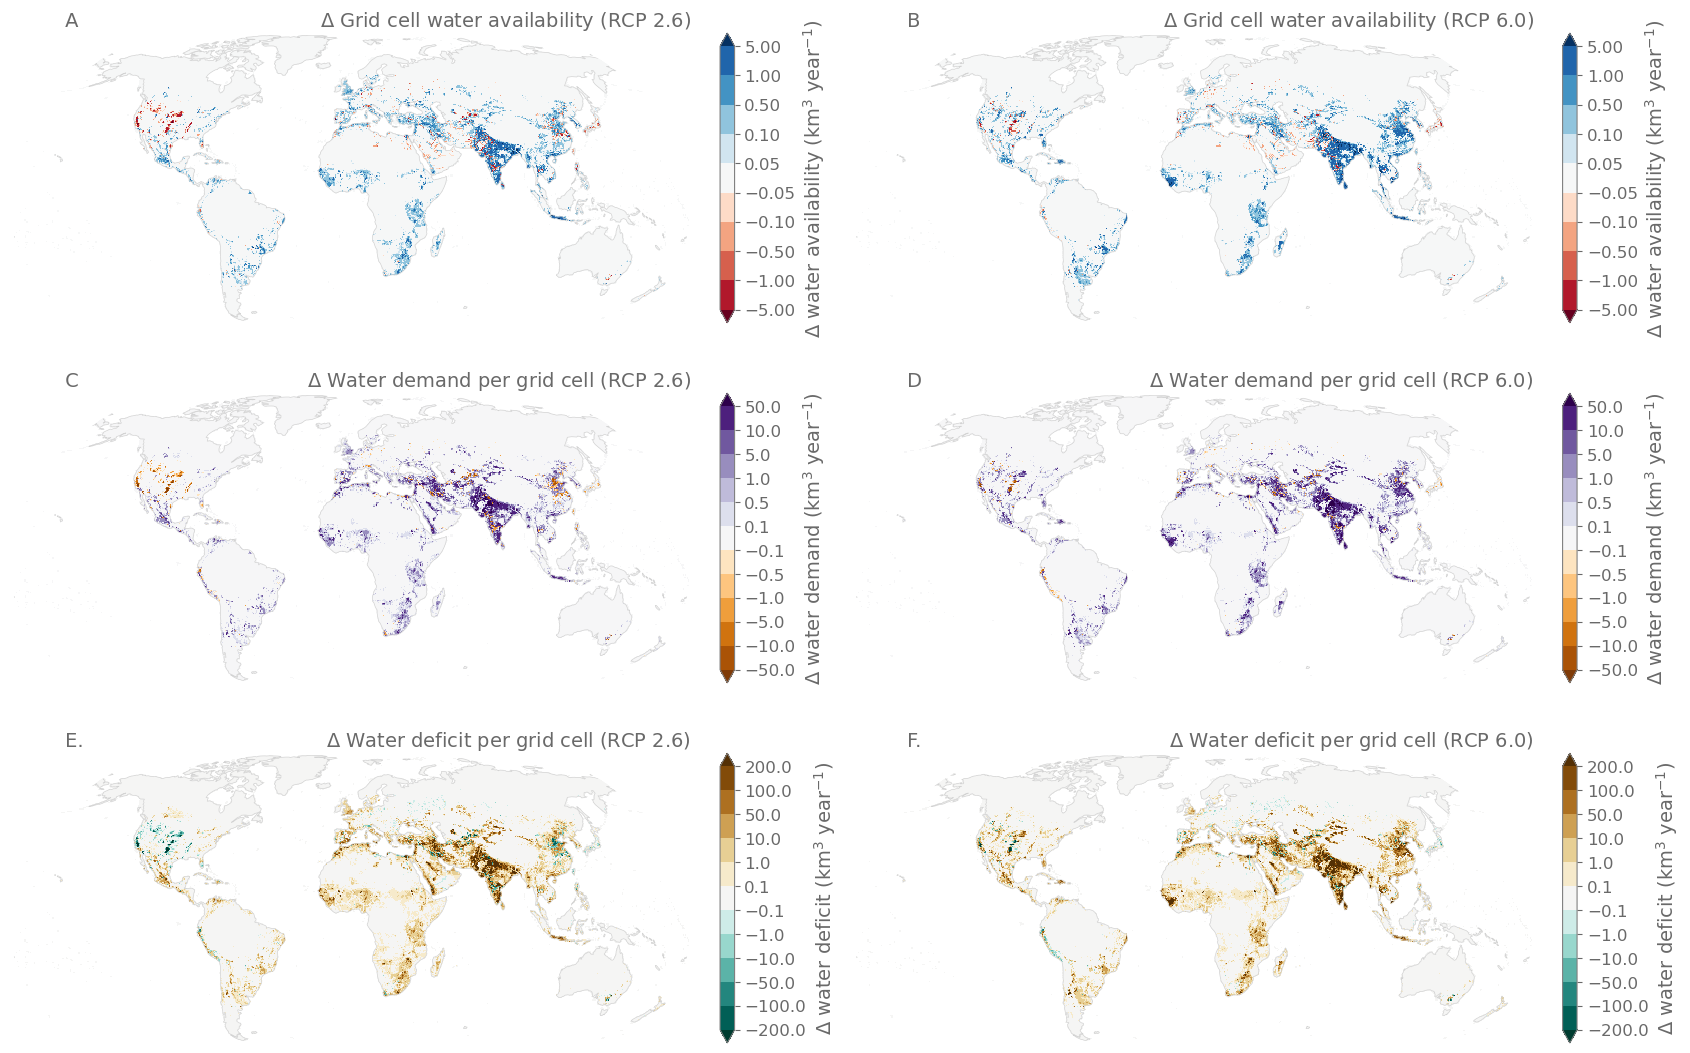

In [23]:

fig, axes = plt.subplots(3,2,figsize=(17,11), subplot_kw={'projection':map_proj})
axes = axes.flatten()

mpl.rc('xtick',labelsize=12)
mpl.rc('ytick',labelsize=12)
mpl.rc('axes',labelsize=14)
title_size = 14

d_rcp_text = {'rcp26':'RCP 2.6', 'rcp60':'RCP 6.0'}

# plot RCP 26
ax= axes[0]
rcp = 'rcp26'
ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)
#levels = [-2e2,-1.5e2,-1.0e2,-0.5e2,-0.1e1,0.1e1,0.5e2,1.0e2,1.5e2,2e2]
#levels = [-50,-25,-10,-5,-1,-0.1,0.1,1,5,10,20,50] 
#levels = [-1,-0.5,-0.1,-0.05,-0.01,0.01,0.05,0.1,0.5,1]
levels = [-10,-5,-1,-0.5,-0.1,-0.05,-0.01,0.01,0.05,0.1,0.5,1,5,10]
levels = [-5,-1,-0.5,-0.1,-0.05,0.05,0.1,0.5,1,5]

delta_availability_rcp60_toplot = d_availability[rcp].where(landmask) * 0.1  # to get from 10**8 m³ to km³

delta_availability_rcp60_toplot.plot(ax=ax, cbar_kwargs={'label': '$\Delta$ water availability (km$^{3}$ year$^{-1}$)', 'fraction': 0.02, 'pad': 0.04, 'ticks' :levels, 'extend': 'both'},levels=levels,cmap='RdBu',transform=ccrs.PlateCarree())

ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('')

rcp_text = d_rcp_text[rcp]


ax.set_title(f'$\Delta$ Grid cell water availability ({rcp_text})', loc='right', fontsize=title_size);
ax.set_title('         A', loc='left', fontsize=title_size);

# plot RCP 60
ax= axes[1]
rcp = 'rcp60'

ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)
#levels = [-2e2,-1.5e2,-1.0e2,-0.5e2,-0.1e1,0.1e1,0.5e2,1.0e2,1.5e2,2e2]
#levels = [-50,-25,-10,-5,-1,-0.1,0.1,1,5,10,20,50] 
#levels = [-1,-0.5,-0.1,-0.05,-0.01,0.01,0.05,0.1,0.5,1]
levels = [-5,-1,-0.5,-0.1,-0.05,0.05,0.1,0.5,1,5]
ticks = levels

delta_availability_rcp60_toplot = d_availability[rcp].where(landmask) * 0.1  # to get from 10**8 m³ to km³

delta_availability_rcp60_toplot.plot(ax=ax, cbar_kwargs={'label': '$\Delta$ water availability (km$^{3}$ year$^{-1}$)', 'fraction': 0.02, 'pad': 0.04, 'ticks' :ticks, 'extend': 'both'},levels=levels,cmap='RdBu',transform=ccrs.PlateCarree())

ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('')

rcp_text = d_rcp_text[rcp]


ax.set_title(f'$\Delta$ Grid cell water availability ({rcp_text})', loc='right', fontsize=title_size);
ax.set_title('         B', loc='left', fontsize=title_size);

# plot RCP 26
ax= axes[2]
rcp = 'rcp26'

ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)
levels = [-50,-10,-5,-1,-0.5,-0.1,0.1,0.5,1,5,10,50]

#levels = [-10,-5,-1,-0.5,-0.1,-0.05,-0.01,0.01,0.05,0.1,0.5,1,5,10]

delta_demand_rcp60_toplot = d_demand[rcp].where(landmask) * 0.1
delta_demand_rcp60_toplot.plot(ax=ax, cbar_kwargs={'label': '$\Delta$ water demand (km$^{3}$ year$^{-1}$)', 'fraction': 0.02, 'pad': 0.04,'ticks': levels, 'extend': 'both'}, cmap='PuOr', levels=levels, transform=ccrs.PlateCarree())

ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('')

rcp_text = d_rcp_text[rcp]

ax.set_title(f'$\Delta$ Water demand per grid cell ({rcp_text})', loc='right', fontsize=title_size);
ax.set_title('         C', loc='left', fontsize=title_size);


# plot RCP 26
ax= axes[3]
rcp = 'rcp60'

ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)
levels = [-100,-50,-10,-1,-0.1,0.1,1,10,50,100,]
#levels = [-10,-5,-1,-0.5,-0.1,-0.05,-0.01,0.01,0.05,0.1,0.5,1,5,10]
#levels = [-50,-10,-5,-1,-0.5,-0.1,0.1,0.5,1,5,10,50]
levels = [-50,-10,-5,-1,-0.5,-0.1,0.1,0.5,1,5,10,50]



delta_demand_rcp60_toplot = d_demand[rcp].where(landmask) * 0.1
delta_demand_rcp60_toplot.plot(ax=ax, cbar_kwargs={'label': '$\Delta$ water demand (km$^{3}$ year$^{-1}$)', 'fraction': 0.02, 'pad': 0.04,'ticks': levels, 'extend': 'both'}, cmap='PuOr', levels=levels, transform=ccrs.PlateCarree())

ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('')

rcp_text = d_rcp_text[rcp]

ax.set_title(f'$\Delta$ Water demand per grid cell ({rcp_text})', loc='right', fontsize=title_size);
ax.set_title('         D', loc='left', fontsize=title_size);


# plot RCP 26
ax= axes[4]
rcp = 'rcp26'

ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)
levels = [-200,-100,-50,-10,-1,-0.1,0.1,1,10,50,100,200]

d_deficit[rcp].plot(ax=ax, cbar_kwargs={'label': '$\Delta$ water deficit (km$^{3}$ year$^{-1}$)', 'fraction': 0.02, 'pad': 0.04,'ticks': levels, 'extend': 'both'}, cmap='BrBG_r', levels=levels, transform=ccrs.PlateCarree())

ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('');

rcp_text = d_rcp_text[rcp]

ax.set_title(f'$\Delta$ Water deficit per grid cell ({rcp_text})', loc='right', fontsize=title_size);
ax.set_title('         E.', loc='left', fontsize=title_size);

# plot RCP 26
ax= axes[5]
rcp = 'rcp60'

ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)
levels = [-200,-100,-50,-10,-1,-0.1,0.1,1,10,50,100,200]

d_deficit[rcp].plot(ax=ax, cbar_kwargs={'label': '$\Delta$ water deficit (km$^{3}$ year$^{-1}$)', 'fraction': 0.02, 'pad': 0.04,'ticks': levels, 'extend': 'both'}, cmap='BrBG_r', levels=levels, transform=ccrs.PlateCarree())

ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('');

rcp_text = d_rcp_text[rcp]

ax.set_title(f'$\Delta$ Water deficit per grid cell ({rcp_text})', loc='right', fontsize=title_size);
ax.set_title('         F.', loc='left', fontsize=title_size);


fig.tight_layout()
plt.savefig('/scratch/brussel/vo/000/bvo00012/vsc10055/waterscarcity/lifetime_exposure_isimip/figures/maps_availability_demand_deficit.png', bbox_inches='tight',dpi=600)



#### absolute

$\Delta$ Water availability per grid cell in 2070-2099


NameError: name 'delta_mmm_perbasin_rcp26' is not defined

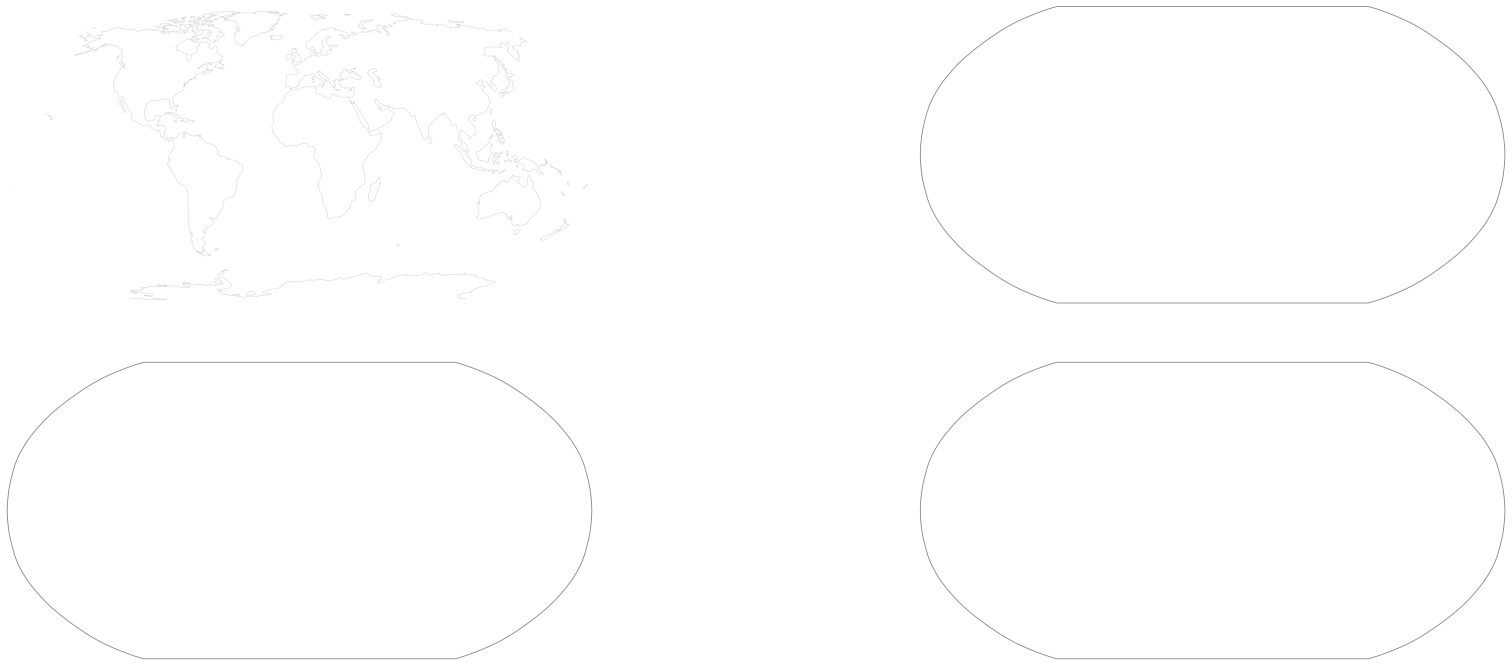

In [25]:
print('$\Delta$ Water availability per grid cell in 2070-2099')

fig, axes = plt.subplots(2,2,figsize=(30,12), subplot_kw={'projection':map_proj})
axes = axes.flatten()

# plot RCP 26
ax= axes[0]

ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)
levels = [-2e2,-1.5e2,-1.0e2,-0.5e2,-0.1e1,0.1e1,0.5e2,1.0e2,1.5e2,2e2]

delta_mmm_perbasin_rcp26.plot(ax=ax, cbar_kwargs={'label': '$\Delta$ water availability (10$^{9}$ m$^{3}$ year$^{-1}$)', 'fraction': 0.02, 'pad': 0.04},levels=levels,  vmin=-2e5, vmax=2e5, cmap='RdBu', transform=ccrs.PlateCarree())

ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('');

ax.set_title(scenario_text['rcp26'], loc='right', fontsize=25);
ax.set_title('                 a.', loc='left', fontsize=20);


# plot RCP 60
ax= axes[1]
levels_pct = [-100,-75,-50,-25,-5,5,25,50,75,100]

ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)

delta_mmm_perbasin_rcp26_rel.plot(ax=ax, cbar_kwargs={'label': '$\Delta$ water availability (%)', 'fraction': 0.02, 'pad': 0.04}, levels=levels_pct, vmin=-100, vmax=100, cmap='RdBu', transform=ccrs.PlateCarree())

ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('');
ax.set_title(scenario_text['rcp26'], loc='right', fontsize=25);
ax.set_title('                 b. ' , loc='left', fontsize=20);


# plot RCP 26
ax= axes[2]

ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)

delta_mmm_perbasin_rcp60.plot(ax=ax, cbar_kwargs={'label': '$\Delta$ water availability (10$^{9}$ m$^{3}$ year$^{-1}$)', 'fraction': 0.02, 'pad': 0.04},levels=levels,  vmin=-2e5, vmax=2e5, cmap='RdBu', transform=ccrs.PlateCarree())

ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('');

ax.set_title(scenario_text['rcp60'], loc='right', fontsize=25);
ax.set_title('                 c.', loc='left', fontsize=20);


# plot RCP 60
ax= axes[3]

ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)

delta_mmm_perbasin_rcp60_rel.plot(ax=ax, cbar_kwargs={'label': '$\Delta$ water availability (%)', 'fraction': 0.02, 'pad': 0.04}, vmin=-100, vmax=100, levels=levels_pct, cmap='RdBu', transform=ccrs.PlateCarree())

ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('');

ax.set_title(scenario_text['rcp60'], loc='right', fontsize=25);
ax.set_title('                 d.', loc='left', fontsize=20);

fig.tight_layout()

plt.savefig('/scratch/brussel/vo/000/bvo00012/vsc10055/waterscarcity/lifetime_exposure_isimip/figures/maps_availability.png', bbox_inches='tight',dpi=600)


In [26]:
# calculate delta's

year_range = range(2070,2099)

delta_mmm_perbasin_rcp26 = calc_exposure_map( 'rcp26', year_range, landmask, models, scenarios, forcings, flag_intermediate=False, flag_perbasin=False, flag_relative = False) *1e-9
# convert from mm/m2s to m3/year
delta_mmm_perbasin_rcp26 = delta_mmm_perbasin_rcp26 * da_cellarea/1000  * secs_in_year

delta_mmm_perbasin_rcp60 = calc_exposure_map('rcp60', year_range, landmask, models, scenarios, forcings, flag_intermediate=False, flag_perbasin=False, flag_relative = False) *1e-9
# convert from mm/m2s to m3/year
delta_mmm_perbasin_rcp60 = delta_mmm_perbasin_rcp60 * da_cellarea/1000  * secs_in_year

# calculate delta's -- RELATIVE
delta_mmm_perbasin_rcp26_rel = calc_exposure_map( 'rcp26', year_range, landmask, models, scenarios, forcings, flag_intermediate=False, flag_perbasin=False, flag_relative = True)

delta_mmm_perbasin_rcp60_rel = calc_exposure_map('rcp60', year_range, landmask, models, scenarios, forcings, flag_intermediate=False, flag_perbasin=False, flag_relative = True)



calculating ref
calculating fut
calculating ref
calculating fut
calculating ref
calculating fut
calculating ref
calculating fut


$\Delta$ Water availability per grid cell in 2070-2099


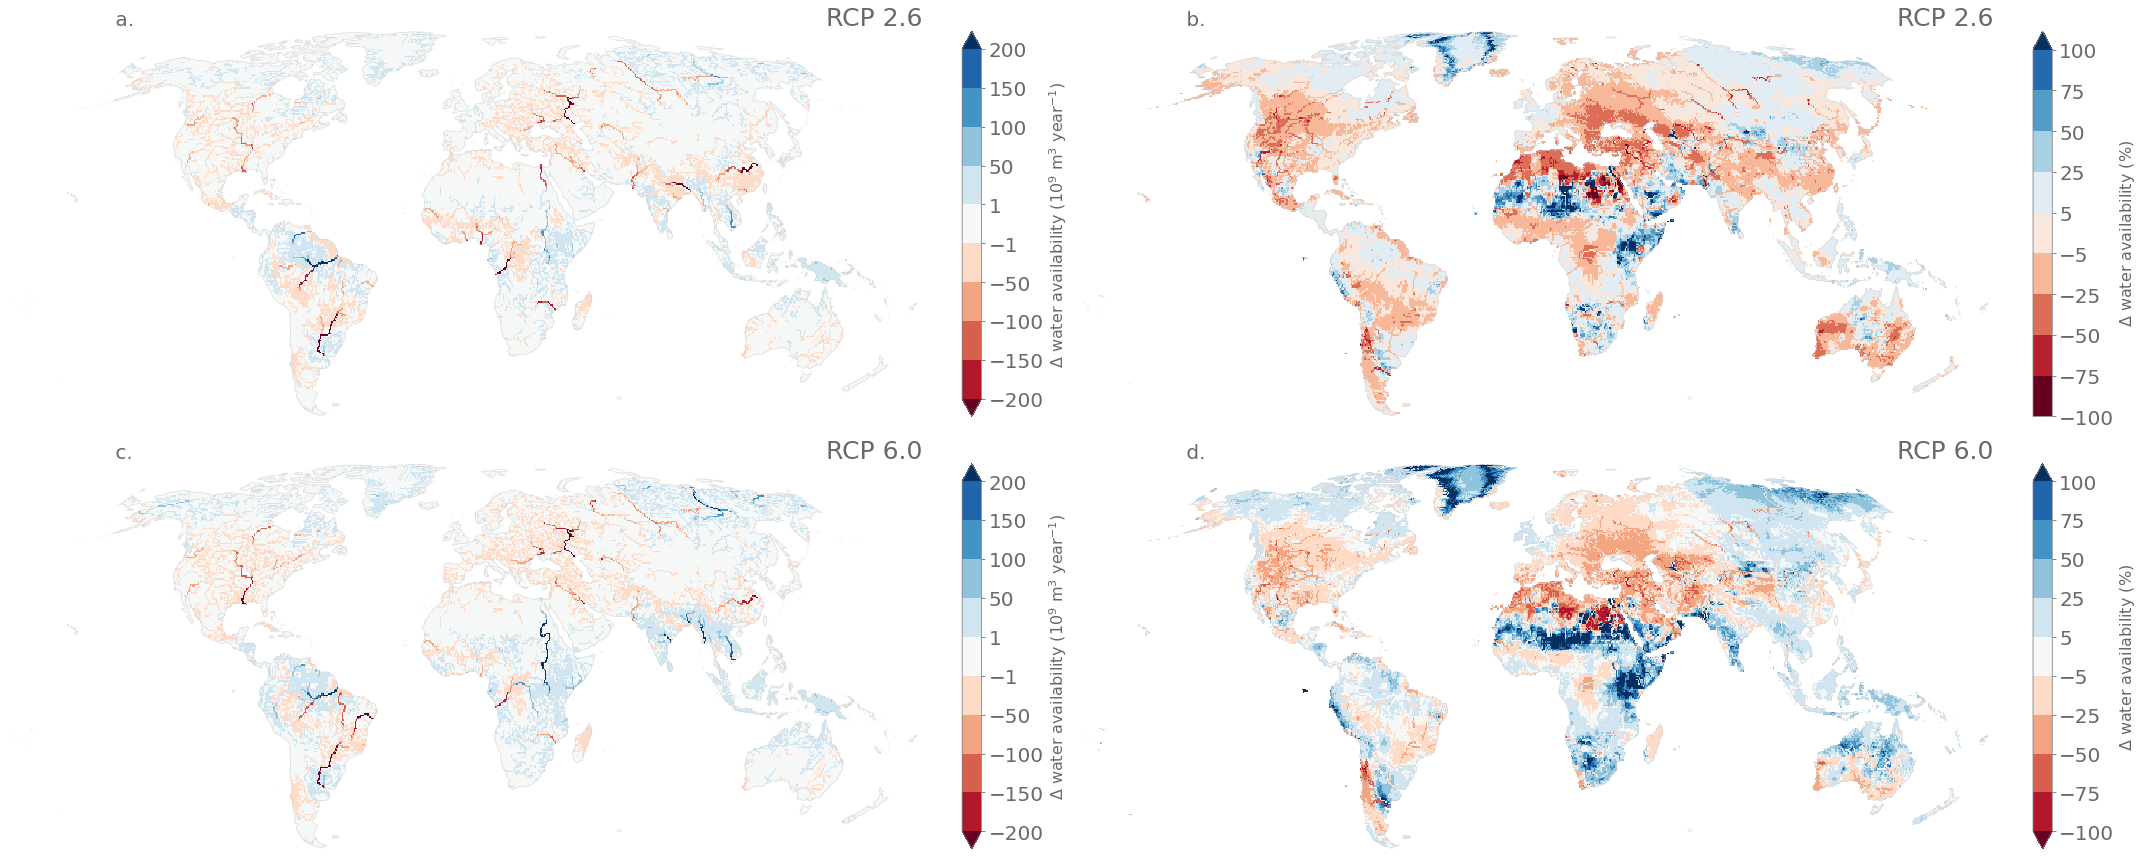

In [27]:
print('$\Delta$ Water availability per grid cell in 2070-2099')

fig, axes = plt.subplots(2,2,figsize=(30,12), subplot_kw={'projection':map_proj})
axes = axes.flatten()

# plot RCP 26
ax= axes[0]

ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)
levels = [-2e2,-1.5e2,-1.0e2,-0.5e2,-0.1e1,0.1e1,0.5e2,1.0e2,1.5e2,2e2]

delta_mmm_perbasin_rcp26.plot(ax=ax, cbar_kwargs={'label': '$\Delta$ water availability (10$^{9}$ m$^{3}$ year$^{-1}$)', 'fraction': 0.02, 'pad': 0.04},levels=levels,  vmin=-2e5, vmax=2e5, cmap='RdBu', transform=ccrs.PlateCarree())

ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('');

ax.set_title(scenario_text['rcp26'], loc='right', fontsize=25);
ax.set_title('                 a.', loc='left', fontsize=20);


# plot RCP 60
ax= axes[1]
levels_pct = [-100,-75,-50,-25,-5,5,25,50,75,100]

ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)

delta_mmm_perbasin_rcp26_rel.plot(ax=ax, cbar_kwargs={'label': '$\Delta$ water availability (%)', 'fraction': 0.02, 'pad': 0.04}, levels=levels_pct, vmin=-100, vmax=100, cmap='RdBu', transform=ccrs.PlateCarree())

ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('');
ax.set_title(scenario_text['rcp26'], loc='right', fontsize=25);
ax.set_title('                 b. ' , loc='left', fontsize=20);


# plot RCP 26
ax= axes[2]

ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)

delta_mmm_perbasin_rcp60.plot(ax=ax, cbar_kwargs={'label': '$\Delta$ water availability (10$^{9}$ m$^{3}$ year$^{-1}$)', 'fraction': 0.02, 'pad': 0.04},levels=levels,  vmin=-2e5, vmax=2e5, cmap='RdBu', transform=ccrs.PlateCarree())

ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('');

ax.set_title(scenario_text['rcp60'], loc='right', fontsize=25);
ax.set_title('                 c.', loc='left', fontsize=20);


# plot RCP 60
ax= axes[3]

ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)

delta_mmm_perbasin_rcp60_rel.plot(ax=ax, cbar_kwargs={'label': '$\Delta$ water availability (%)', 'fraction': 0.02, 'pad': 0.04}, vmin=-100, vmax=100, levels=levels_pct, cmap='RdBu', transform=ccrs.PlateCarree())

ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('');

ax.set_title(scenario_text['rcp60'], loc='right', fontsize=25);
ax.set_title('                 d.', loc='left', fontsize=20);

fig.tight_layout()

plt.savefig('/scratch/brussel/vo/000/bvo00012/vsc10055/waterscarcity/lifetime_exposure_isimip/figures/maps_availability.png', bbox_inches='tight',dpi=600)


$\Delta$ Water availability in 2070-2099 (RCP 6.0 - RCP 2.6)


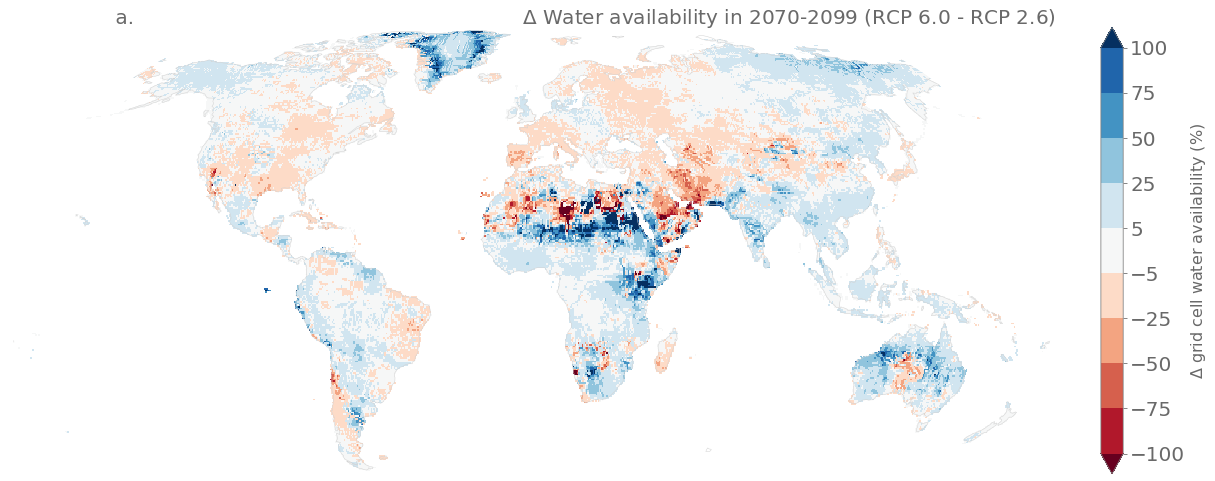

In [28]:
delta_mmm_perbasin_rel = delta_mmm_perbasin_rcp60_rel - delta_mmm_perbasin_rcp26_rel 

print('$\Delta$ Water availability in 2070-2099 (RCP 6.0 - RCP 2.6)')

fig, ax = plt.subplots(1,1,figsize=(20,20), subplot_kw={'projection':map_proj})

levels = [-100,-75,-50,-25,-5,5,25,50,75,100]

ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)

delta_mmm_perbasin_rel.plot(ax=ax, cbar_kwargs={'label': '$\Delta$ grid cell water availability (%)', 'fraction': 0.02, 'pad': 0.04}, cmap='RdBu', levels=levels, transform=ccrs.PlateCarree())

ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('');

ax.set_title('$\Delta$ Water availability in 2070-2099 (RCP 6.0 - RCP 2.6)', loc='right', fontsize=20);
ax.set_title('                 a.', loc='left', fontsize=20);


$\Delta$ Water availability in 2070-2099 (RCP 6.0 - RCP 2.6)


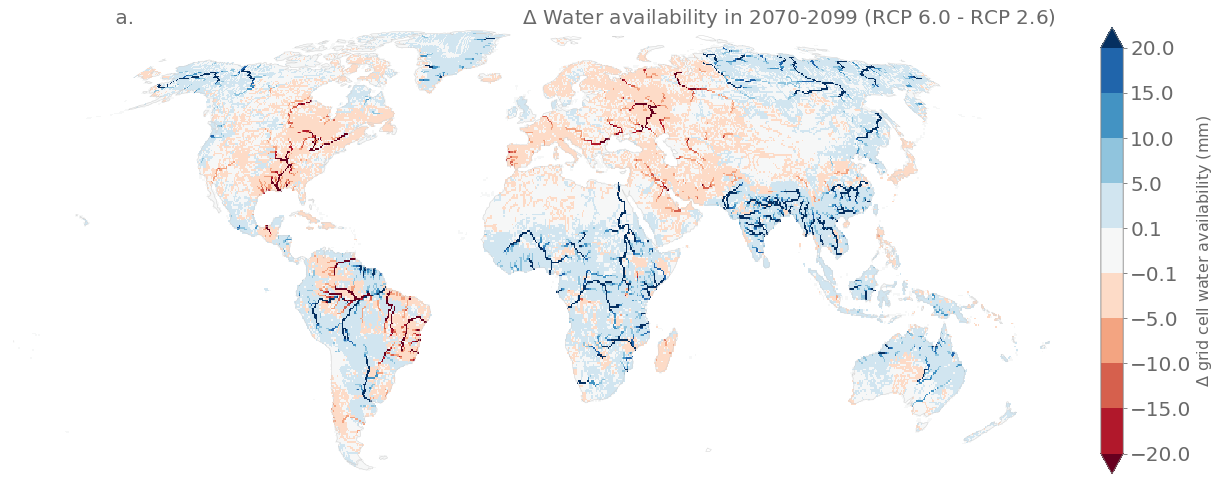

In [29]:
delta_mmm_perbasin = delta_mmm_perbasin_rcp60 - delta_mmm_perbasin_rcp26 

print('$\Delta$ Water availability in 2070-2099 (RCP 6.0 - RCP 2.6)')

fig, ax = plt.subplots(1,1,figsize=(20,20), subplot_kw={'projection':map_proj})

levels = np.array([-2e2,-1.5e2,-1.0e2,-0.5e2,-0.1e1,0.1e1,0.5e2,1.0e2,1.5e2,2e2]) * 0.1

ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)

delta_mmm_perbasin.plot(ax=ax, cbar_kwargs={'label': '$\Delta$ grid cell water availability (mm)', 'fraction': 0.02, 'pad': 0.04}, cmap='RdBu', levels=levels, transform=ccrs.PlateCarree())

ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('');

ax.set_title('$\Delta$ Water availability in 2070-2099 (RCP 6.0 - RCP 2.6)', loc='right', fontsize=20);
ax.set_title('                 a.', loc='left', fontsize=20);


## DEFICIT

In [30]:
# calculate delta's

year_range = range(2070,2099)

delta_mmm_perbasin_rcp26 = calc_deficit_map( 'rcp26', year_range, landmask, models, scenarios, forcings, flag_intermediate=False, flag_perbasin=False, flag_relative = False) *1e-9
# convert from mm/m2s to m3/year
delta_mmm_perbasin_rcp26 = (delta_mmm_perbasin_rcp26 * da_cellarea/1000  * secs_in_year).where(landmask)

delta_mmm_perbasin_rcp60 = calc_deficit_map('rcp60', year_range, landmask, models, scenarios, forcings, flag_intermediate=False, flag_perbasin=False, flag_relative = False) *1e-9
# convert from mm/m2s to m3/year
delta_mmm_perbasin_rcp60 = (delta_mmm_perbasin_rcp60 * da_cellarea/1000  * secs_in_year).where(landmask)

# calculate delta's -- RELATIVE
delta_mmm_perbasin_rcp26_rel = calc_deficit_map( 'rcp26', year_range, landmask, models, scenarios, forcings, flag_intermediate=False, flag_perbasin=False, flag_relative = True)

delta_mmm_perbasin_rcp60_rel = calc_deficit_map('rcp60', year_range, landmask, models, scenarios, forcings, flag_intermediate=False, flag_perbasin=False, flag_relative = True)



calculating ref
calculating fut
calculating ref
calculating fut
calculating ref
calculating fut
calculating ref
calculating fut


$\Delta$ Water deficit per grid cell in 2070-2099


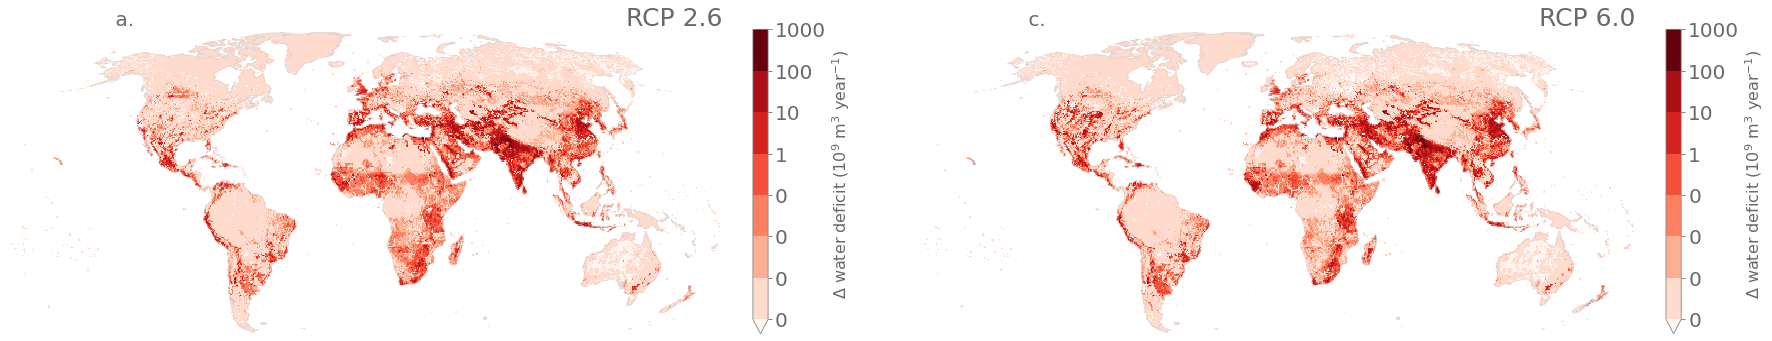

In [31]:
print('$\Delta$ Water deficit per grid cell in 2070-2099')

fig, axes = plt.subplots(1,2,figsize=(30,6), subplot_kw={'projection':map_proj})
axes = axes.flatten()

# plot RCP 26
ax= axes[0]

ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)
levels = [-2e2,-1.5e2,-1.0e2,-0.5e2,-0.1e1,0.1e1,0.5e2,1.0e2,1.5e2,2e2]
levels = [0,0.001,0.01,0.1,1,10,100,1000]

delta_mmm_perbasin_rcp26.plot(ax=ax, cbar_kwargs={'label': '$\Delta$ water deficit (10$^{9}$ m$^{3}$ year$^{-1}$)', 'fraction': 0.02, 'pad': 0.04},levels=levels, cmap='Reds', transform=ccrs.PlateCarree())

# vmin=-2e5, vmax=2e5,
# levels=levels,


ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('');

ax.set_title(scenario_text['rcp26'], loc='right', fontsize=25);
ax.set_title('                 a.', loc='left', fontsize=20);


# plot RCP 26
ax= axes[1]

ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)

delta_mmm_perbasin_rcp60.where(landmask).plot(ax=ax, cbar_kwargs={'label': '$\Delta$ water deficit (10$^{9}$ m$^{3}$ year$^{-1}$)', 'fraction': 0.02, 'pad': 0.04},levels=levels, cmap='Reds', transform=ccrs.PlateCarree())

ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('');

ax.set_title(scenario_text['rcp60'], loc='right', fontsize=25);
ax.set_title('                 c.', loc='left', fontsize=20);


plt.savefig('/scratch/brussel/vo/000/bvo00012/vsc10055/waterscarcity/lifetime_exposure_isimip/figures/maps_deficit.png', bbox_inches='tight',dpi=600)


$\Delta$ mean annual water deficit in 2070-2099 (RCP 6.0 - RCP 2.6)


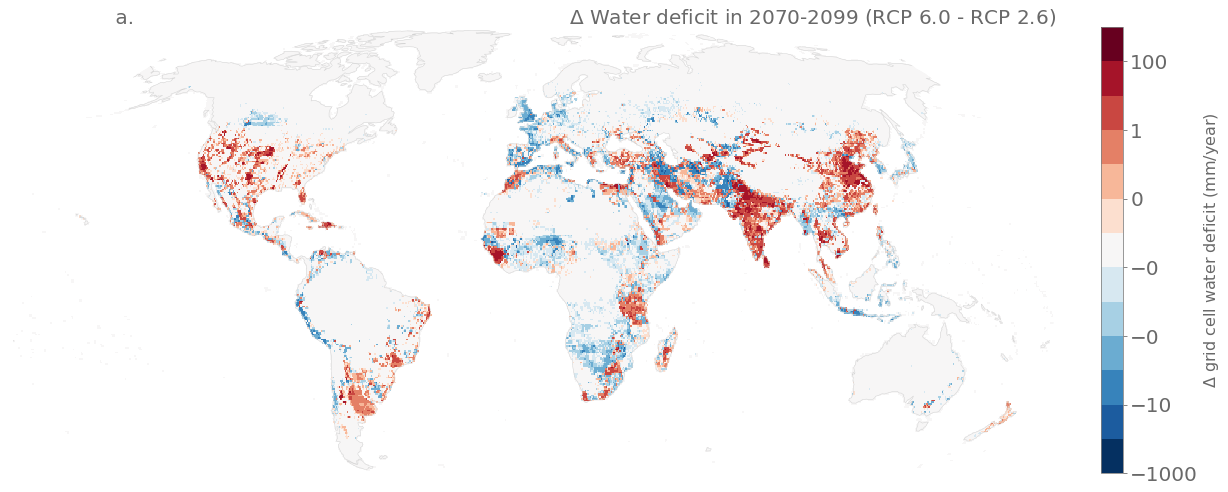

In [32]:
delta_mmm_perbasin = delta_mmm_perbasin_rcp60 - delta_mmm_perbasin_rcp26 

print('$\Delta$ mean annual water deficit in 2070-2099 (RCP 6.0 - RCP 2.6)')

fig, ax = plt.subplots(1,1,figsize=(20,20), subplot_kw={'projection':map_proj})

levels = np.array([-2e2,-1.5e2,-1.0e2,-0.5e2,-0.1e1,0.1e1,0.5e2,1.0e2,1.5e2,2e2]) *0.1
levels = [-1000,-100,-10,-1,-0.1,-0.01,-0.001,0.001,0.01,0.1,1,10,100,1000]

ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)

delta_mmm_perbasin.plot(ax=ax, cbar_kwargs={'label': '$\Delta$ grid cell water deficit (mm/year)', 'fraction': 0.02, 'pad': 0.04}, cmap='RdBu_r', levels=levels, transform=ccrs.PlateCarree())

ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('');

ax.set_title('$\Delta$ Water deficit in 2070-2099 (RCP 6.0 - RCP 2.6)', loc='right', fontsize=20);
ax.set_title('                 a.', loc='left', fontsize=20);


$\Delta$ Water deficit in 2070-2099 (RCP 6.0 - RCP 2.6)


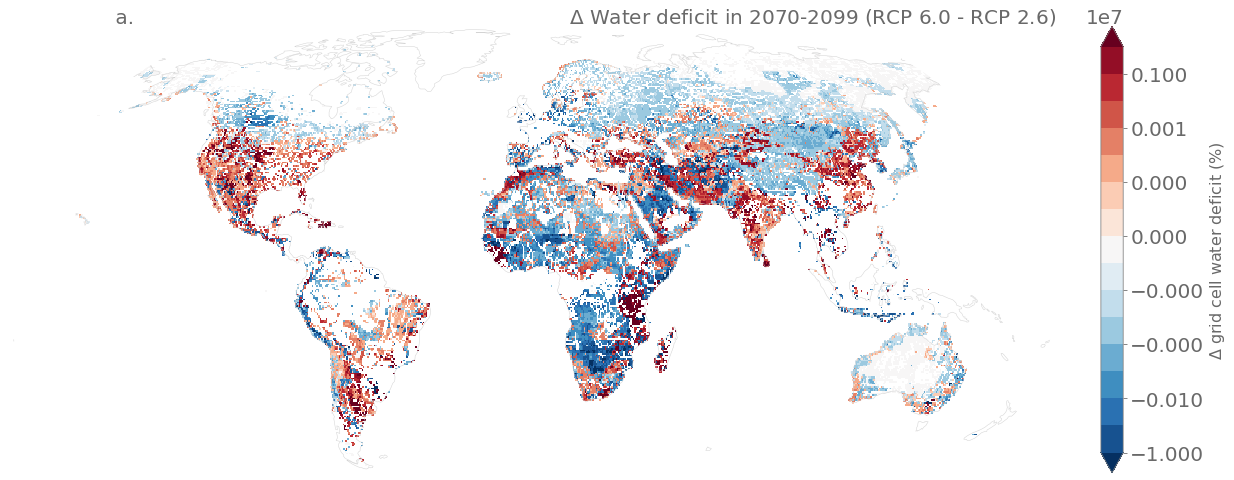

In [33]:
delta_mmm_perbasin_rel = delta_mmm_perbasin_rcp60_rel - delta_mmm_perbasin_rcp26_rel 

print('$\Delta$ Water deficit in 2070-2099 (RCP 6.0 - RCP 2.6)')

fig, ax = plt.subplots(1,1,figsize=(20,20), subplot_kw={'projection':map_proj})

levels = np.array([-1e7,-1e6,-1e5,-10000,-1000,-100,-10,-1,1,10,100,1000,10000,1e5,1e6,1e7]) 

ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)

delta_mmm_perbasin_rel.plot(ax=ax, cbar_kwargs={'label': '$\Delta$ grid cell water deficit (%)', 'fraction': 0.02, 'pad': 0.04}, cmap='RdBu_r', levels=levels, transform=ccrs.PlateCarree())

ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('');

ax.set_title('$\Delta$ Water deficit in 2070-2099 (RCP 6.0 - RCP 2.6)', loc='right', fontsize=20);
ax.set_title('                 a.', loc='left', fontsize=20);


## OLD

In [34]:
# calculate delta's -- BASINS

year_range = range(2070,2099)

delta_mmm_perbasin_rcp26 = calc_exposure_map( 'rcp26', year_range, landmask, models, scenarios, forcings, flag_intermediate=False, flag_perbasin=False, flag_relative = False)

delta_mmm_perbasin_rcp60 = calc_exposure_map('rcp60', year_range, landmask, models, scenarios, forcings, flag_intermediate=False, flag_perbasin=False, flag_relative = False)


calculating ref
calculating fut
calculating ref
calculating fut


## same for defcits

In [ ]:
print('$\Delta$ Water availability in 2070-2099')

fig, axes = plt.subplots(2,1,figsize=(45,20), subplot_kw={'projection':map_proj})
axes = axes.flatten()

# plot RCP 26
ax= axes[0]

ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)

delta_mmm_perbasin_rcp26.plot(ax=ax, cbar_kwargs={'label': '$\Delta$ grid cell water availability (%)', 'fraction': 0.02, 'pad': 0.04}, vmin=-100, vmax=100, cmap='RdBu', transform=ccrs.PlateCarree())

ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('');

ax.set_title(scenario_text['rcp26'], loc='right', fontsize=20);
ax.set_title('                 a.', loc='left', fontsize=20);


# plot RCP 60
ax= axes[1]

ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)

delta_mmm_perbasin_rcp60.plot(ax=ax, cbar_kwargs={'label': '$\Delta$ grid cell water availability (%)', 'fraction': 0.02, 'pad': 0.04}, vmin=-100, vmax=100, cmap='RdBu', transform=ccrs.PlateCarree())

ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('');

ax.set_title(scenario_text['rcp60'], loc='right', fontsize=20);
ax.set_title('                 b.', loc='left', fontsize=20);



## OLD

In [ ]:
delta_mmm_perbasin = calc_exposure_map(variable, GMT_offset, GMT_level, landmask, models, scenarios, forcings, flag_intermediate=True, flag_perbasin=True, flag_relative=False)


In [ ]:
fig, ax = plt.subplots(figsize=(18,10), subplot_kw={'projection':map_proj})
ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)

delta_mmm_perbasin.plot(ax=ax, cbar_kwargs={'label': '$\Delta$ grid cell water availability mm/m²s', 'fraction': 0.02, 'pad': 0.04}, cmap='RdBu', vmax=0.04, vmin = -0.04, transform=ccrs.PlateCarree())
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title(' ');

ax.set_title('$\Delta$ water availability at +'+str(GMT_level)+'° GMT ', loc='right');

#### relative

In [9]:
delta_mmm_perbasin = calc_exposure_map(variable, GMT_offset, GMT_level, landmask, models, scenarios, forcings, flag_intermediate=True, flag_perbasin=False, flag_relative=True)


calculating ref
calculating fut


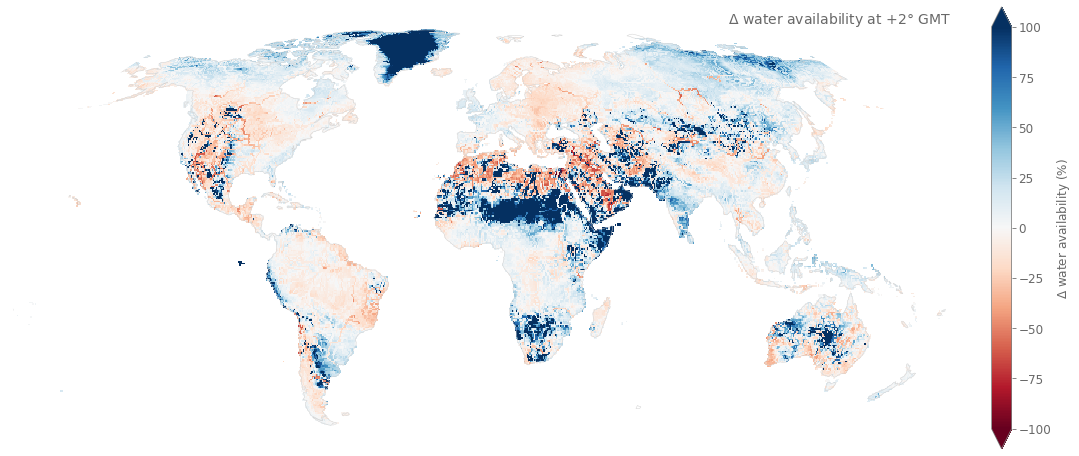

In [10]:

fig, ax = plt.subplots(figsize=(18,10), subplot_kw={'projection':map_proj})
ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)

delta_mmm_perbasin.plot(ax=ax, cbar_kwargs={'label': '$\Delta$ water availability (%)', 'fraction': 0.02, 'pad': 0.04}, cmap='RdBu', vmax=100, vmin = -100, transform=ccrs.PlateCarree())
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('');

ax.set_title('$\Delta$ water availability at +'+str(GMT_level)+'° GMT ', loc='right');



In [11]:
variable='q_avail'
GMT_level = 2

delta_mmm_perbasin = calc_exposure_map(variable, GMT_offset, GMT_level, landmask, models, scenarios, forcings, flag_intermediate=True, flag_perbasin=True, flag_relative=True)


calculating ref
calculating fut
calculating means per basin


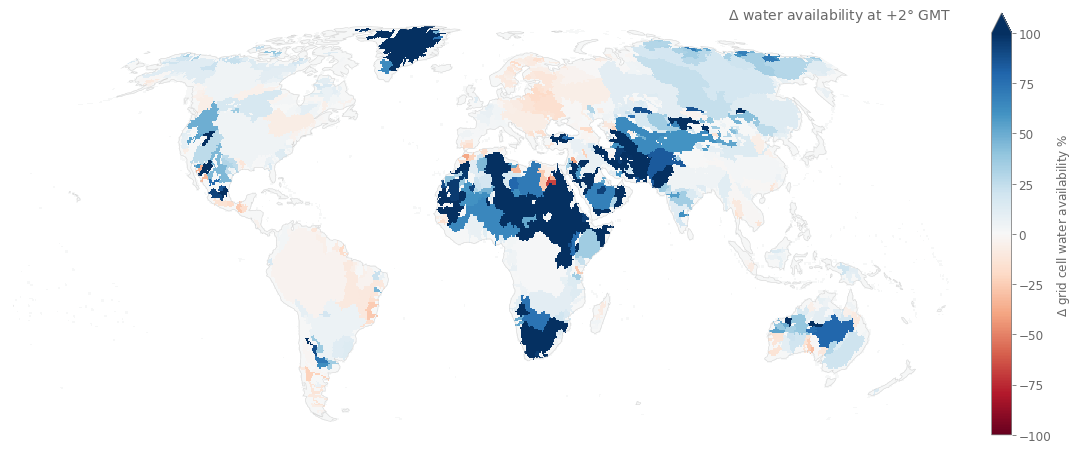

In [12]:


fig, ax = plt.subplots(figsize=(18,10), subplot_kw={'projection':map_proj})
ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)

delta_mmm_perbasin.plot(ax=ax, cbar_kwargs={'label': '$\Delta$ grid cell water availability %', 'fraction': 0.02, 'pad': 0.04}, cmap='RdBu', vmax=100, vmin = -100, transform=ccrs.PlateCarree())
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('$\Delta$ water availability at +'+str(GMT_level)+'° GMT ', loc='right');
ax.set_title('');



### +1° GMT

In [13]:
variable='q_avail'
GMT_level = 1


#### absolute

In [14]:
delta_mmm_perbasin = calc_exposure_map(variable, GMT_offset, GMT_level, landmask, models, scenarios, forcings, flag_intermediate=True, flag_perbasin=False, flag_relative=False)

calculating ref
calculating fut


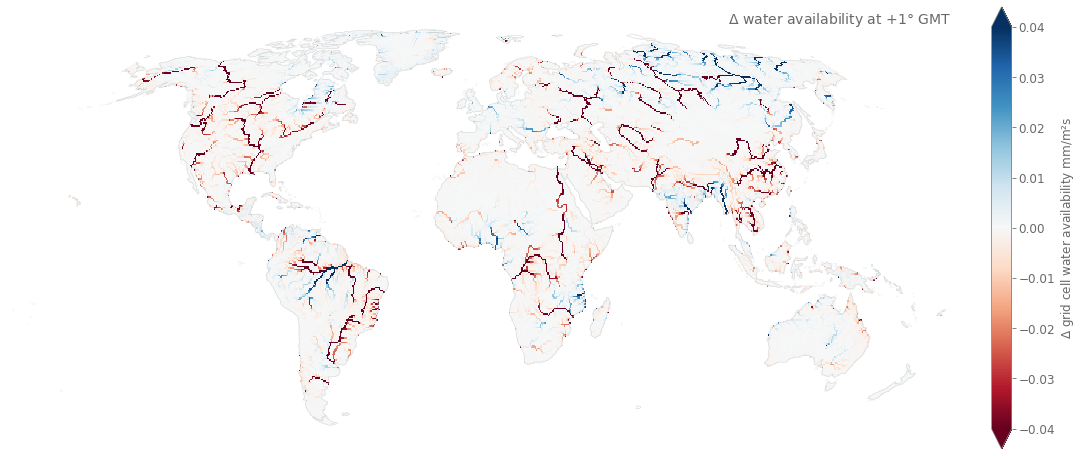

In [15]:

fig, ax = plt.subplots(figsize=(18,10), subplot_kw={'projection':map_proj})
ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)

delta_mmm_perbasin.plot(ax=ax, cbar_kwargs={'label': '$\Delta$ grid cell water availability mm/m²s', 'fraction': 0.02, 'pad': 0.04}, cmap='RdBu', vmax=0.04, vmin = -0.04, transform=ccrs.PlateCarree())
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('');

ax.set_title('$\Delta$ water availability at +'+str(GMT_level)+'° GMT ', loc='right');



In [16]:
delta_mmm_perbasin = calc_exposure_map(variable, GMT_offset, GMT_level, landmask, models, scenarios, forcings, flag_intermediate=True, flag_perbasin=True, flag_relative=False)

calculating ref
calculating fut
calculating means per basin


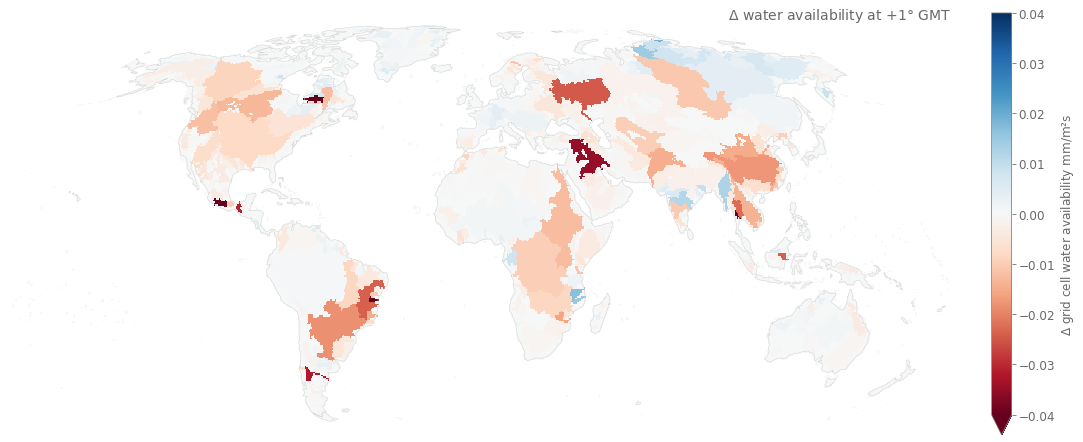

In [17]:

fig, ax = plt.subplots(figsize=(18,10), subplot_kw={'projection':map_proj})
ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)

delta_mmm_perbasin.plot(ax=ax, cbar_kwargs={'label': '$\Delta$ grid cell water availability mm/m²s', 'fraction': 0.02, 'pad': 0.04}, cmap='RdBu', vmax=0.04, vmin = -0.04, transform=ccrs.PlateCarree())
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title(' ');

ax.set_title('$\Delta$ water availability at +'+str(GMT_level)+'° GMT ', loc='right');


#### relative

In [18]:
delta_mmm_perbasin = calc_exposure_map(variable, GMT_offset, GMT_level, landmask, models, scenarios, forcings, flag_intermediate=True, flag_perbasin=True, flag_relative=True)


calculating ref
calculating fut
calculating means per basin


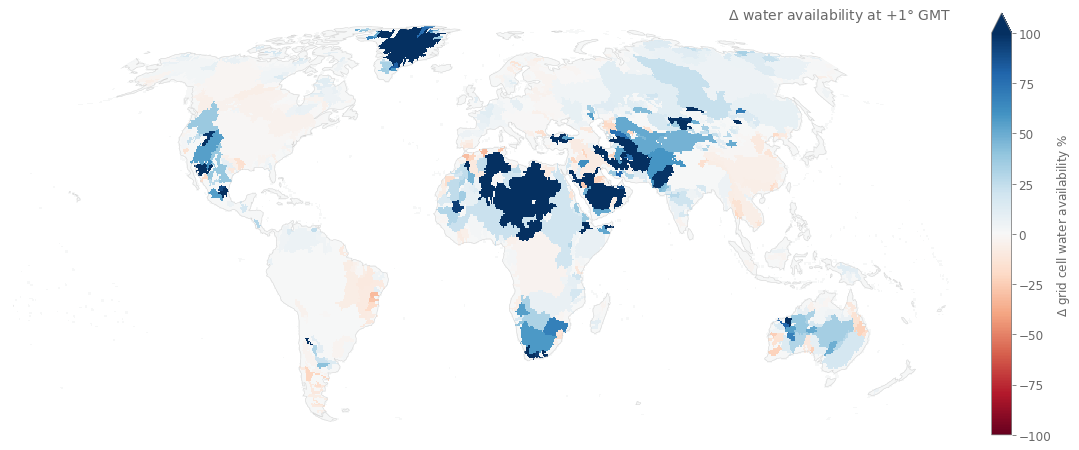

In [19]:

fig, ax = plt.subplots(figsize=(18,10), subplot_kw={'projection':map_proj})
ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)

delta_mmm_perbasin.plot(ax=ax, cbar_kwargs={'label': '$\Delta$ grid cell water availability %', 'fraction': 0.02, 'pad': 0.04}, cmap='RdBu', vmax=100, vmin = -100, transform=ccrs.PlateCarree())
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('$\Delta$ water availability at +'+str(GMT_level)+'° GMT ', loc='right');
ax.set_title('');



In [20]:
delta_mmm_perbasin = calc_exposure_map(variable, GMT_offset, GMT_level, landmask, models, scenarios, forcings, flag_intermediate=True, flag_perbasin=False, flag_relative=True)


calculating ref
calculating fut


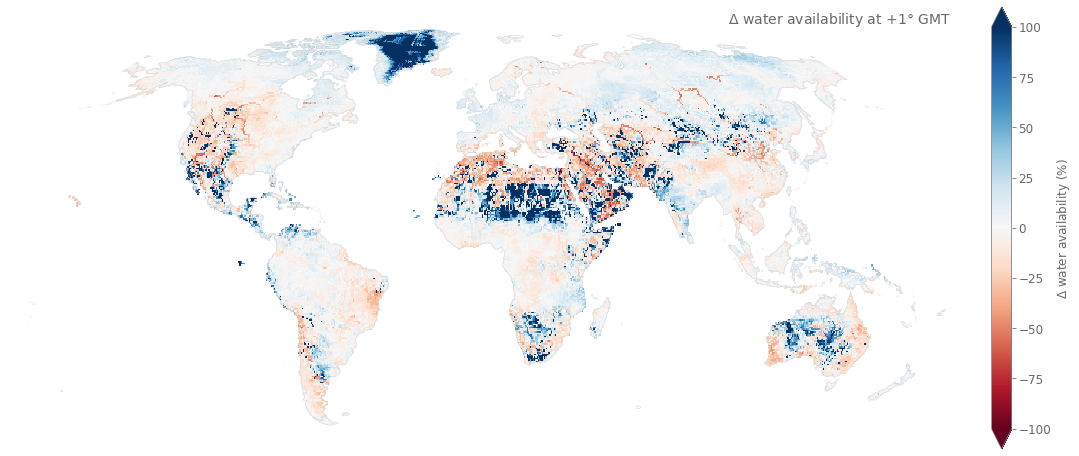

In [21]:

fig, ax = plt.subplots(figsize=(18,10), subplot_kw={'projection':map_proj})
ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)

delta_mmm_perbasin.plot(ax=ax, cbar_kwargs={'label': '$\Delta$ water availability (%)', 'fraction': 0.02, 'pad': 0.04}, cmap='RdBu', vmax=100, vmin = -100, transform=ccrs.PlateCarree())
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('');

ax.set_title('$\Delta$ water availability at +'+str(GMT_level)+'° GMT ', loc='right');



### +3° GMT

In [22]:
variable='q_avail'
GMT_level = 3


#### absolute

In [23]:
delta_mmm_perbasin = calc_exposure_map(variable, GMT_offset, GMT_level, landmask, models, scenarios, forcings, flag_intermediate=True, flag_perbasin=False, flag_relative=False)

calculating ref
calculating fut


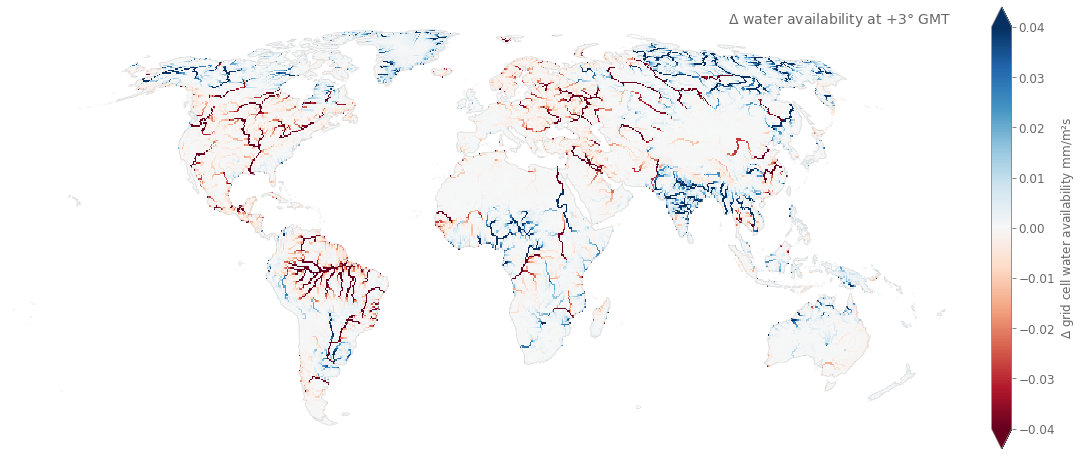

In [24]:

fig, ax = plt.subplots(figsize=(18,10), subplot_kw={'projection':map_proj})
ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)

delta_mmm_perbasin.plot(ax=ax, cbar_kwargs={'label': '$\Delta$ grid cell water availability mm/m²s', 'fraction': 0.02, 'pad': 0.04}, cmap='RdBu', vmax=0.04, vmin = -0.04, transform=ccrs.PlateCarree())
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('');

ax.set_title('$\Delta$ water availability at +'+str(GMT_level)+'° GMT ', loc='right');



In [25]:
delta_mmm_perbasin = calc_exposure_map(variable, GMT_offset, GMT_level, landmask, models, scenarios, forcings, flag_intermediate=True, flag_perbasin=True, flag_relative=False)

calculating ref
calculating fut
calculating means per basin


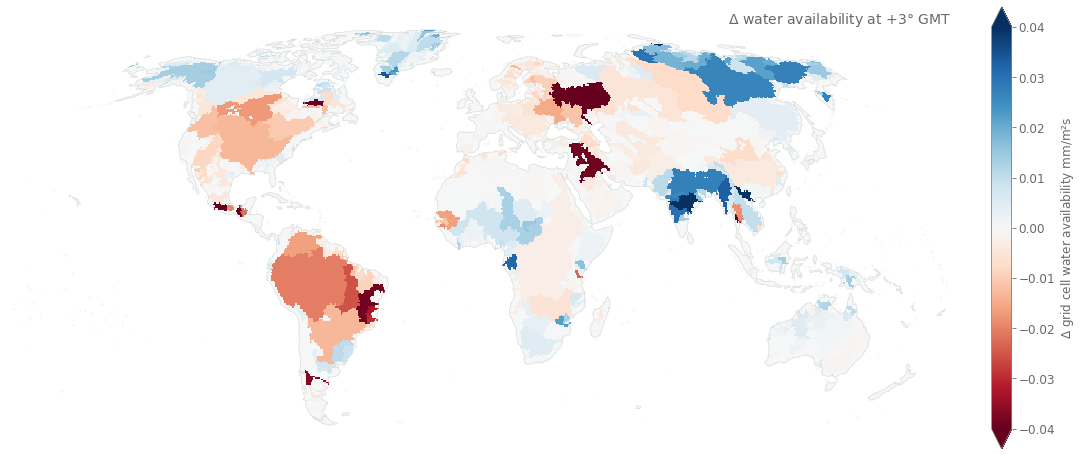

In [26]:

fig, ax = plt.subplots(figsize=(18,10), subplot_kw={'projection':map_proj})
ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)

delta_mmm_perbasin.plot(ax=ax, cbar_kwargs={'label': '$\Delta$ grid cell water availability mm/m²s', 'fraction': 0.02, 'pad': 0.04}, cmap='RdBu', vmax=0.04, vmin = -0.04, transform=ccrs.PlateCarree())
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title(' ');

ax.set_title('$\Delta$ water availability at +'+str(GMT_level)+'° GMT ', loc='right');


#### relative

In [27]:
delta_mmm_perbasin = calc_exposure_map(variable, GMT_offset, GMT_level, landmask, models, scenarios, forcings, flag_intermediate=True, flag_perbasin=True, flag_relative=True)


calculating ref
calculating fut
calculating means per basin


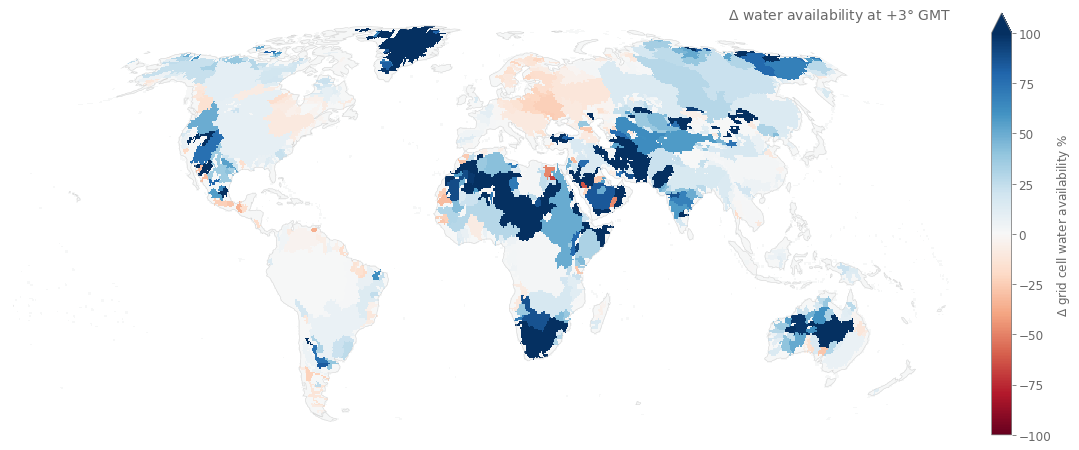

In [28]:

fig, ax = plt.subplots(figsize=(18,10), subplot_kw={'projection':map_proj})
ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)

delta_mmm_perbasin.plot(ax=ax, cbar_kwargs={'label': '$\Delta$ grid cell water availability %', 'fraction': 0.02, 'pad': 0.04}, cmap='RdBu', vmax=100, vmin = -100, transform=ccrs.PlateCarree())
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('$\Delta$ water availability at +'+str(GMT_level)+'° GMT ', loc='right');
ax.set_title('');

In [29]:
delta_mmm_perbasin = calc_exposure_map(variable, GMT_offset, GMT_level, landmask, models, scenarios, forcings, flag_intermediate=True, flag_perbasin=False, flag_relative=True)


calculating ref
calculating fut


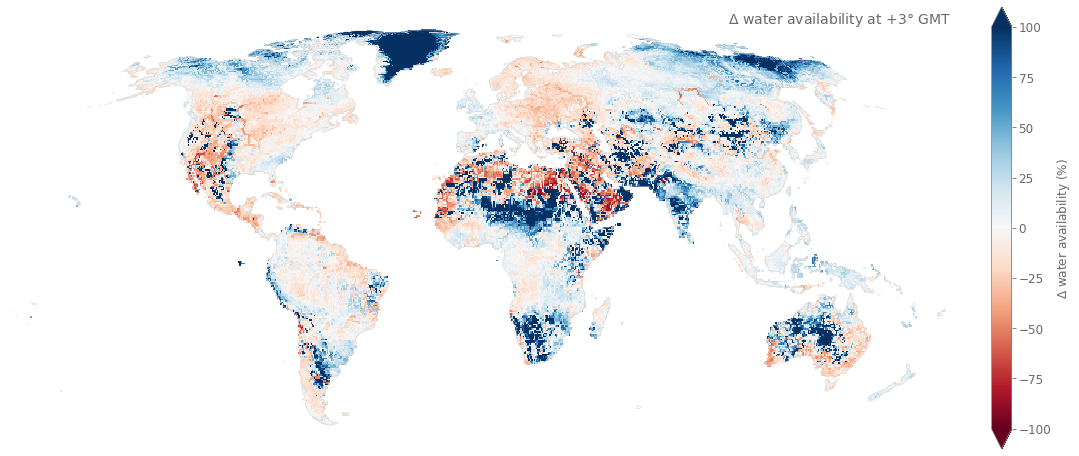

In [30]:

fig, ax = plt.subplots(figsize=(18,10), subplot_kw={'projection':map_proj})
ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)

delta_mmm_perbasin.plot(ax=ax, cbar_kwargs={'label': '$\Delta$ water availability (%)', 'fraction': 0.02, 'pad': 0.04}, cmap='RdBu', vmax=100, vmin = -100, transform=ccrs.PlateCarree())
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('');

ax.set_title('$\Delta$ water availability at +'+str(GMT_level)+'° GMT ', loc='right');


### OLD

calculating ref
calculating fut
calculating means per basin


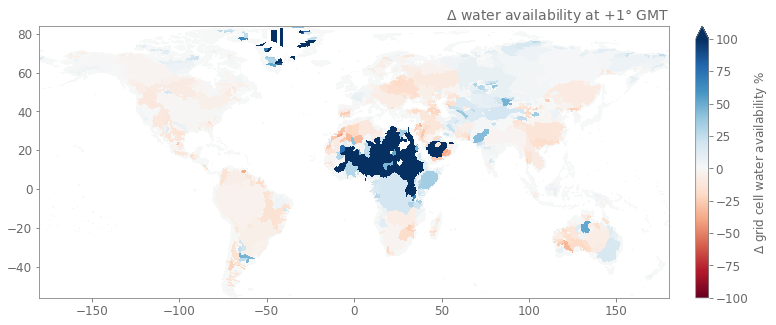

In [30]:
variable='q_avail'
GMT_level = 1

delta_mmm_perbasin = calc_exposure_map(variable, GMT_offset, GMT_level, landmask, models, scenarios, forcings, flag_intermediate=True, flag_perbasin=True, flag_relative=True)



fig, ax = plt.subplots(figsize=(18,10), subplot_kw={'projection':map_proj})
ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)

delta_mmm_perbasin.plot(ax=ax, cbar_kwargs={'label': '$\Delta$ grid cell water availability %', 'fraction': 0.02, 'pad': 0.04}, cmap='RdBu', vmax=100, vmin = -100, transform=ccrs.PlateCarree())
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('$\Delta$ water availability at +'+str(GMT_level)+'° GMT ', loc='right');




calculating ref
calculating fut


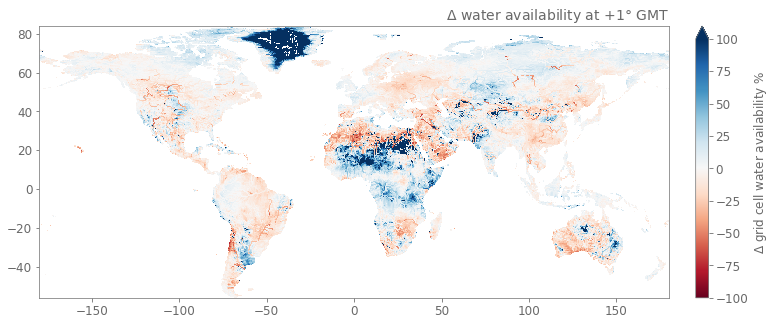

In [35]:
variable='q_avail'
GMT_level = 1

delta_mmm_perbasin = calc_exposure_map(variable, GMT_offset, GMT_level, landmask, models, scenarios, forcings, flag_intermediate=True, flag_perbasin=False, flag_relative=True)


fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)
delta_mmm_perbasin.plot(ax=ax, cbar_kwargs={'label': '$\Delta$ grid cell water availability %', 'fraction': 0.02, 'pad': 0.04}, cmap='RdBu', vmax=100, vmin = -100, transform=ccrs.PlateCarree())
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('$\Delta$ water availability at +'+str(GMT_level)+'° GMT ', loc='right');




calculating ref
calculating fut


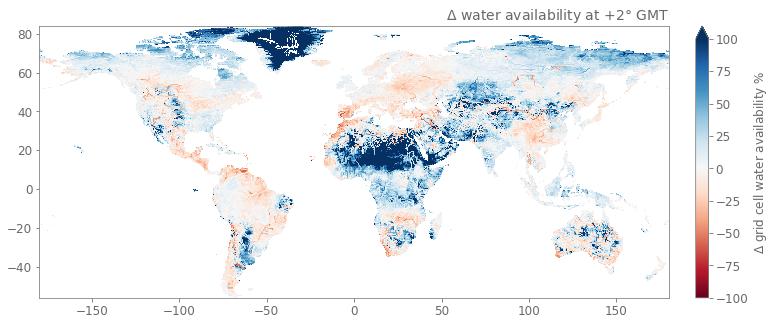

In [34]:
variable='q_avail'
GMT_level = 2

delta_mmm_perbasin = calc_exposure_map(variable, GMT_offset, GMT_level, landmask, models, scenarios, forcings, flag_intermediate=True, flag_perbasin=False, flag_relative=True)


fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)
delta_mmm_perbasin.plot(ax=ax, cbar_kwargs={'label': '$\Delta$ grid cell water availability %', 'fraction': 0.02, 'pad': 0.04}, cmap='RdBu', vmax=100, vmin = -100, transform=ccrs.PlateCarree())
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('$\Delta$ water availability at +'+str(GMT_level)+'° GMT ', loc='right');




calculating ref
calculating fut


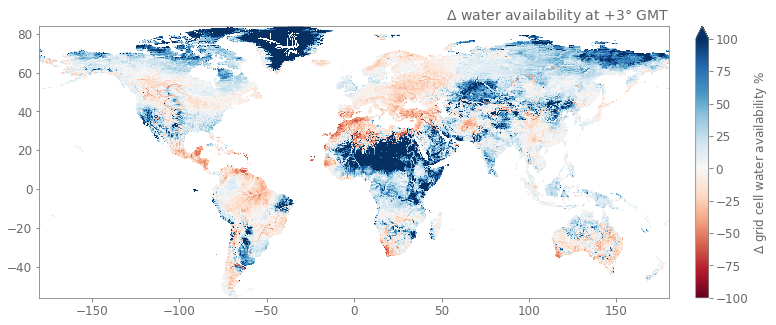

In [36]:
variable='q_avail'
GMT_level = 3

delta_mmm_perbasin = calc_exposure_map(variable, GMT_offset, GMT_level, landmask, models, scenarios, forcings, flag_intermediate=True, flag_perbasin=False, flag_relative=True)


fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)
delta_mmm_perbasin.plot(ax=ax, cbar_kwargs={'label': '$\Delta$ grid cell water availability %', 'fraction': 0.02, 'pad': 0.04}, cmap='RdBu', vmax=100, vmin = -100, transform=ccrs.PlateCarree())
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('$\Delta$ water availability at +'+str(GMT_level)+'° GMT ', loc='right');




calculating ref
calculating fut
calculating means per basin


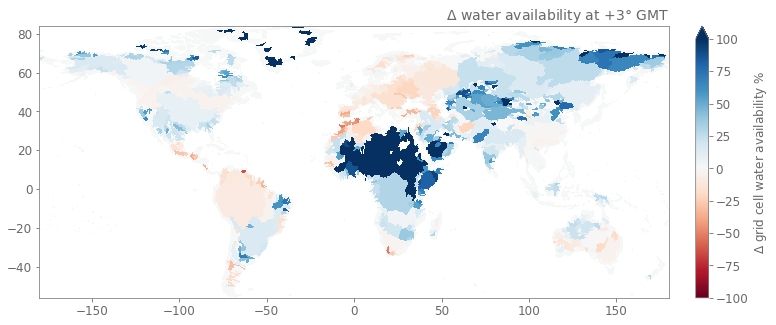

In [33]:
variable='q_avail'
GMT_level = 3

delta_mmm_perbasin = calc_exposure_map(variable, GMT_offset, GMT_level, landmask, models, scenarios, forcings, flag_intermediate=True, flag_perbasin=True, flag_relative=True)


fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)
delta_mmm_perbasin.plot(ax=ax, cbar_kwargs={'label': '$\Delta$ grid cell water availability %', 'fraction': 0.02, 'pad': 0.04}, cmap='RdBu', vmax=100, vmin = -100, transform=ccrs.PlateCarree())
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('$\Delta$ water availability at +'+str(GMT_level)+'° GMT ', loc='right');




calculating ref
calculating fut
calculating means per basin


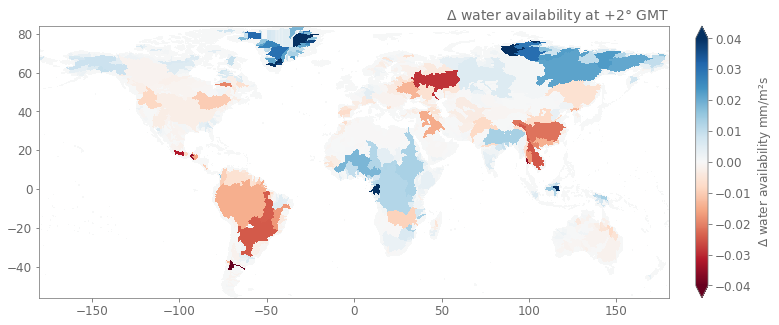

In [19]:
variable='q_avail'
GMT_level = 2

delta_mmm_perbasin = calc_exposure_map(variable, GMT_offset, GMT_level, landmask, models, scenarios, forcings, flag_intermediate=True, flag_perbasin=True)


fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)
delta_mmm_perbasin.plot(ax=ax, cbar_kwargs={'label': '$\Delta$ water availability mm/m²s', 'fraction': 0.02, 'pad': 0.04}, cmap='RdBu', vmax=0.04, vmin = -0.04, transform=ccrs.PlateCarree())
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('$\Delta$ water availability at +'+str(GMT_level)+'° GMT ', loc='right');




calculating ref
calculating fut
calculating means per basin


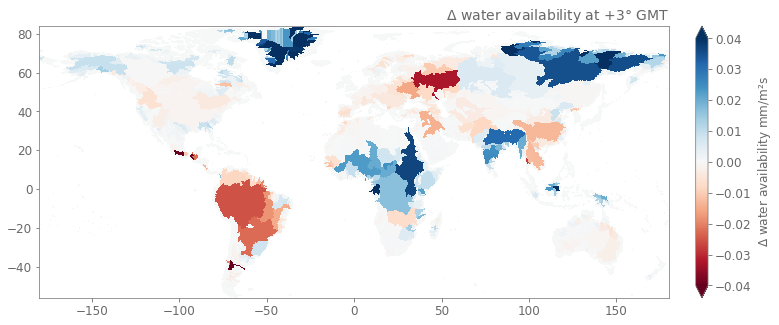

In [17]:
variable='q_avail'
GMT_level = 3

delta_mmm_perbasin = calc_exposure_map(variable, GMT_offset, GMT_level, landmask, models, scenarios, forcings, flag_intermediate=True, flag_perbasin=True)


fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)
delta_mmm_perbasin.plot(ax=ax, cbar_kwargs={'label': '$\Delta$ water availability mm/m²s', 'fraction': 0.02, 'pad': 0.04}, cmap='RdBu', vmax=0.04, vmin = -0.04)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('$\Delta$ water availability at +'+str(GMT_level)+'° GMT ', loc='right');




In [16]:
variable='qtot'
GMT_level = 2

delta_mmm_perbasin = calc_exposure_map(variable, GMT_offset, GMT_level, landmask, models, scenarios, forcings, flag_intermediate=True, flag_perbasin=True)


fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)
delta_mmm_perbasin.plot(ax=ax, cbar_kwargs={'label': '$\Delta$ runoff mm/s', 'fraction': 0.02, 'pad': 0.04}, cmap='RdBu', vmax=0.04, vmin = -0.04)#, vmax=0.05, vmin = -0.05)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('$\Delta$ runoff at +'+str(GMT_level)+'° GMT ', loc='right');




calculating ref


ValueError: 'qtot' is not present in all datasets.

In [ ]:
variable='dis_directupstream'
GMT_level = 2

delta_mmm_perbasin = calc_exposure_map(variable, GMT_offset, GMT_level, landmask, models, scenarios, forcings, flag_intermediate=True, flag_perbasin=True)


fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)
delta_mmm_perbasin.plot(ax=ax, cbar_kwargs={'label': '$\Delta$ discharge from directly upstream m³/s', 'fraction': 0.02, 'pad': 0.04}, cmap='RdBu')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('$\Delta$ discharge from directly upstream at +'+str(GMT_level)+'° GMT ', loc='right');




In [15]:
plot_exposure_map('dis_directupstream', GMT_offset, GMT_levels, landmask, models, scenarios, forcings, flag_intermediate=True)

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/brussel/vo/000/bvo00012/vsc10055/waterscarcity/lifetime_exposure_isimip/data/isimip/dis_directupstream/watergap2-2e/'

## Intermediate variables

### Water availability

In [4]:
# plot with all forcings
variable = 'q_avail'

mask= landmask
ds = load_intermediate_variable_ds(variable, mask,  models, scenarios, forcings)

fig, ax = plt.subplots(figsize=(12,6))

# loop over models
for i, scenario in enumerate(scenarios):
    for forcing in forcings: 
        da_sel = ds[variable].sel({'scenario':scenario,'forcing':forcing})

        da_sel.mean(dim=('model')).plot(ax=ax, label =scenario)

ax.legend()
ax.set_ylabel('mm/m²')
ax.set_title('')

Loading model LPJmL
No LPJmL gfdl-esm2m historical simulations for q_avail_


IndexError: list index out of range

Loading model LPJmL
Loading model CWatM
Loading model MATSIRO
Loading model H08


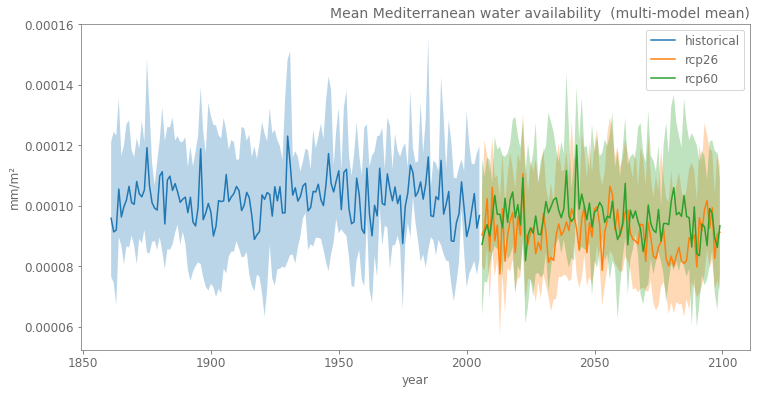

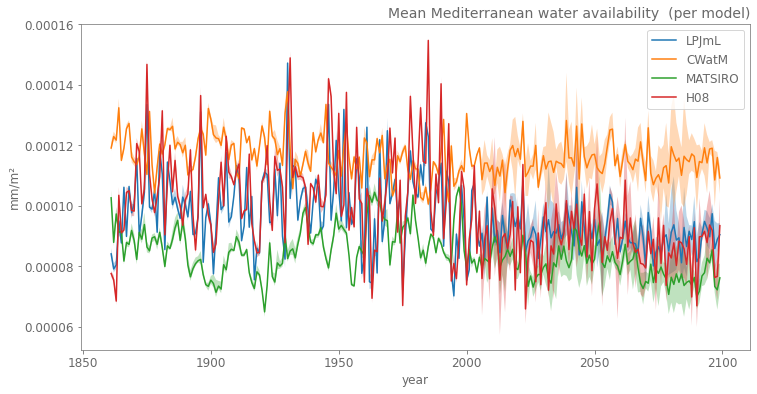

In [7]:
# global mean 
variable = 'q_avail'
mask = med_mask #global
plot_intermediate_variable(variable, med_mask, models, scenarios, forcings)

### Potential total water withdrawal

Loading model LPJmL
Loading model CWatM
Loading model MATSIRO
Loading model H08


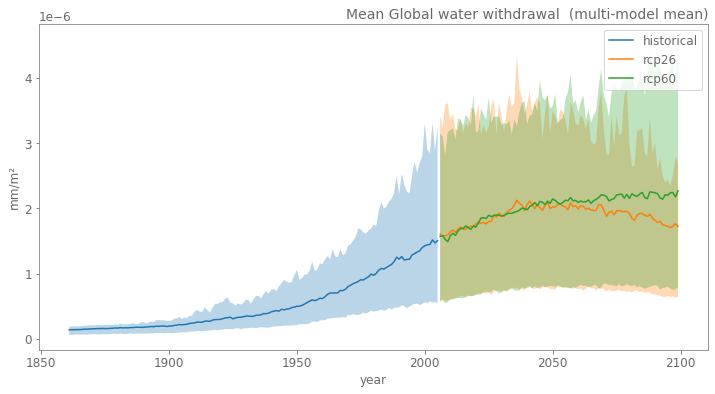

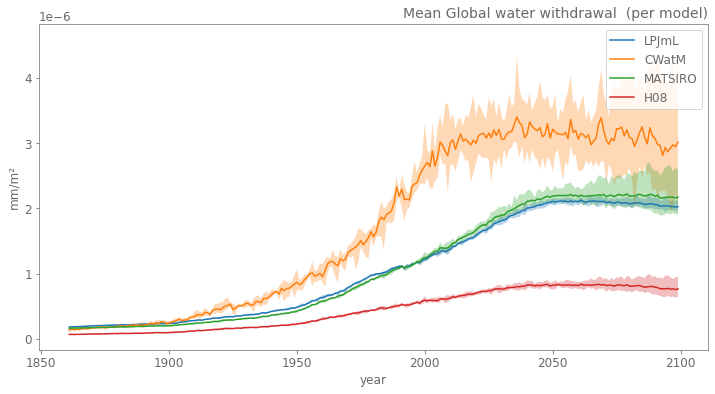

In [8]:
# global mean 
variable = 'ptotww'
mask = landmask # global
plot_intermediate_variable(variable, mask, models, scenarios, forcings)

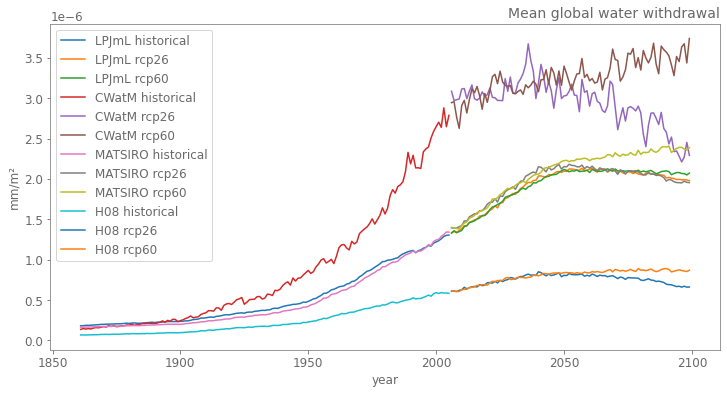

In [24]:
# plot with scenario and model
variable= 'ptotww'
mask = landmask
ds = load_intermediate_variable_ds(variable, mask,  models, scenarios, forcings)


fig, ax = plt.subplots(figsize=(12,6))

# loop over models
for model in models: 
    for i, scenario in enumerate(scenarios):
        da_sel = ds.mean('forcing').sel({'scenario':scenario,'model':model})

        da_sel.plot(ax=ax, label = model+' '+scenario)

ax.legend()
ax.set_ylabel('mm/m²')
ax.set_title('')
ax.set_title('Mean global water withdrawal', loc='right');

Loading model LPJmL
Loading model CWatM
Loading model MATSIRO
Loading model H08


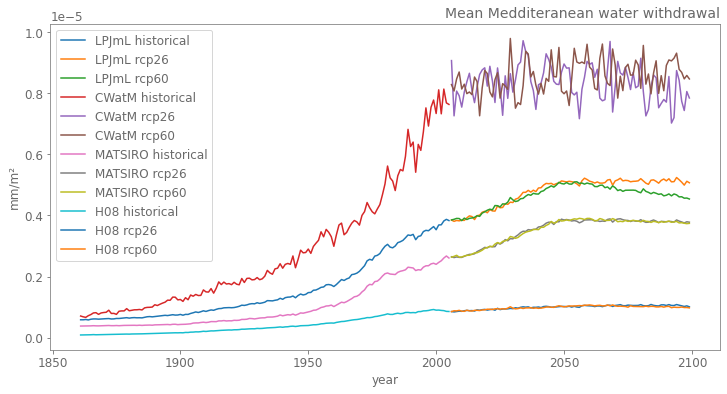

In [25]:
# plot with scenario and model
variable= 'ptotww'
mask = med_mask
ds = load_intermediate_variable_ds(variable, mask,  models, scenarios, forcings)


fig, ax = plt.subplots(figsize=(12,6))

# loop over models
for model in models: 
    for i, scenario in enumerate(scenarios):
        da_sel = ds.mean('forcing').sel({'scenario':scenario,'model':model})

        da_sel.plot(ax=ax, label = model+' '+scenario)

ax.legend()
ax.set_ylabel('mm/m²')
ax.set_title('')
ax.set_title('Mean Medditeranean water withdrawal', loc='right');

Loading model LPJmL
Loading model CWatM
Loading model MATSIRO
Loading model H08


Text(0.5, 1.0, '')

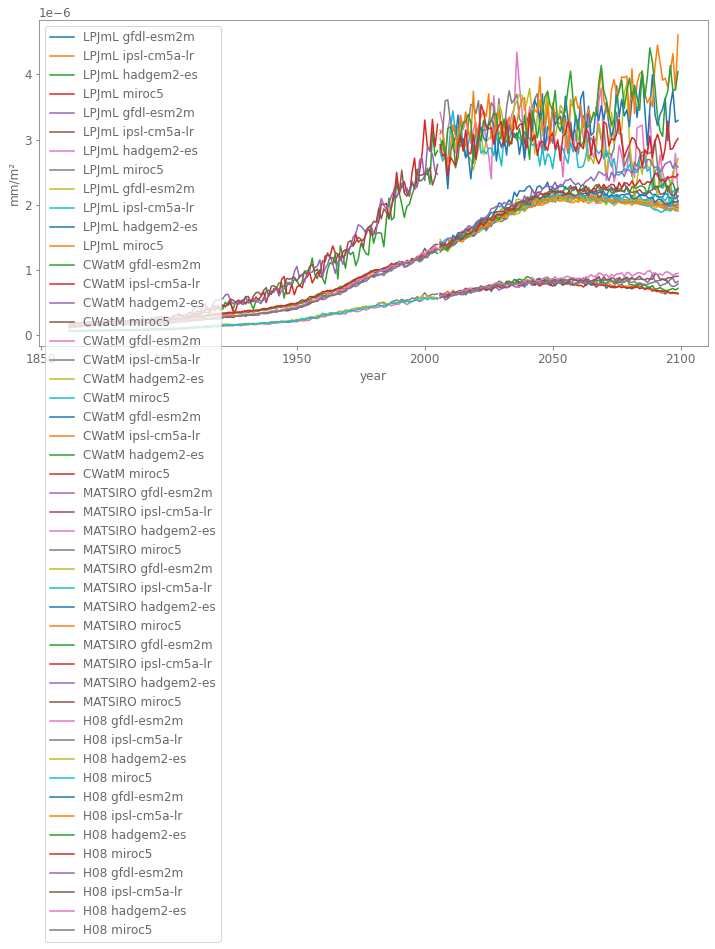

In [9]:
# plot with all forcings
variable= 'ptotww'
mask = landmask
ds = load_intermediate_variable_ds(variable, mask,  models, scenarios, forcings)
fig, ax = plt.subplots(figsize=(12,6))

# loop over models
for model in models: 
    for i, scenario in enumerate(scenarios):
        for forcing in forcings: 
            da_sel = ds.sel({'scenario':scenario,'forcing':forcing,'model':model})

            da_sel.plot(ax=ax, label = model+' '+forcing)

ax.legend()
ax.set_ylabel('mm/m²')
ax.set_title('')

# OLD

Loading model WaterGAP2-2e
Loading model CWatM
Loading model H08


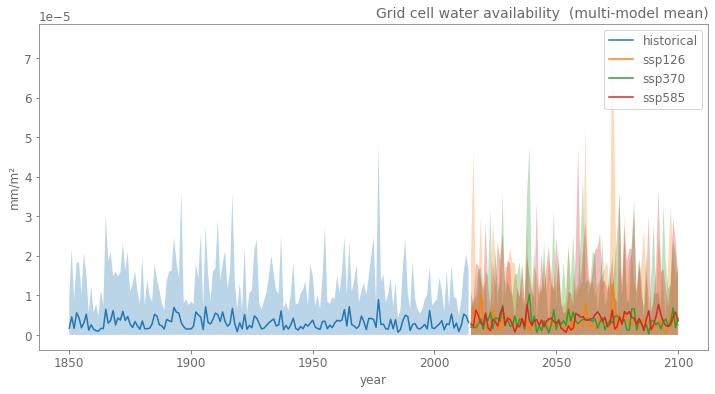

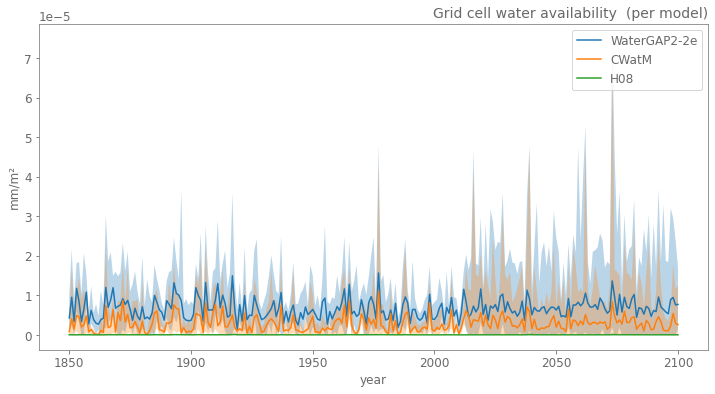

In [12]:
# Middle East
lat_sel = 30.75
lon_sel = 39.25


variable = 'q_avail'
mode = [lat_sel, lon_sel]
plot_intermediate_variable(variable, landmask, models, scenarios, forcings, mode)

In [30]:
variable = 'ptotww'
mode = [lat_sel, lon_sel]
plot_intermediate_variable(variable, landmask, models, scenarios, forcings, mode)

NameError: name 'lat_sel' is not defined

In [ ]:
for i, model in enumerate(models): 
    ds_ptotww_all = load_intermediate_variable_ds('ptotww', [model], scenarios, forcings)

    if i == 0: 
        ds_ptotww = ds_ptotww_all['ptotww'].mean(dim='forcing').to_dataset(name='mean_'+models[i])
    else: 
        ds_ptotww['mean_'+models[i]] = ds_ptotww_all['ptotww'].squeeze().mean(dim='forcing')

    ds_ptotww['min_'+models[i]] = ds_ptotww_all['ptotww'].squeeze().min(dim='forcing')
    ds_ptotww['max_'+models[i]] = ds_ptotww_all['ptotww'].squeeze().max(dim='forcing')

    del ds_ptotww_all

Loading model CWatM


In [46]:
# load and calculate multimodel mean and min and max for plotting
for model in models: 
    ds_waterscarcity_index = load_intermediate_variable_ds('waterscarcity_index', [model], scenarios, forcings)

    if i == 0: 
        ds_ws = ds_waterscarcity_index['wsindex'].mean(dim='forcing').to_dataset(name='mean_'+models[i])
    else: 
        ds_ws['mean_'+models[i]] = ds_waterscarcity_index['wsindex'].squeeze().mean(dim='forcing')
    ds_ws['min_'+models[i]] = ds_waterscarcity_index['wsindex'].squeeze().min(dim='forcing')
    ds_ws['max_'+models[i]] = ds_waterscarcity_index['wsindex'].squeeze().max(dim='forcing')
    del ds_waterscarcity_index


Loading model W


FileNotFoundError: [Errno 2] No such file or directory: '/theia/scratch/brussel/vo/000/bvo00012/vsc10055/waterscarcity/waterscarcity_isimip/data/intermediate//w/'

In [71]:
ds_median = ds_waterscarcity_index['wsindex'].squeeze().median(dim=('lat','lon'))
ds_median_ptotww = ds_ptotww['ptotww'].squeeze().median(dim=('lat','lon'))
ds_median_q_avail = ds_qavail['q_avail'].squeeze().median(dim=('lat','lon'))

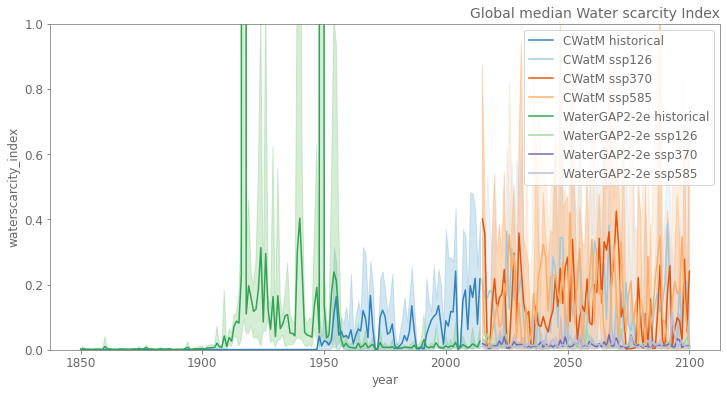

In [42]:
# per model and scenario
# southern Spain
lat_sel = 36.75
lon_sel = -118.75


colors = iter([plt.cm.tab20c(i) for i in range(20)])

ds_ws_toplot = ds_ws.squeeze().sel({'lat':lat_sel,'lon':lon_sel})
fig, ax = plt.subplots(figsize=(12,6))

for model in models: 
    # loop over models
    for i, scenario in enumerate(scenarios):
        

            ds_ws_toplot['mean_'+model].sel({'scenario':scenario}).plot(ax=ax, label = model+' '+scenario, color=next(colors))
            ax.fill_between(ds_ws_toplot['min_'+model].sel({'scenario':scenario}).year,ds_ws_toplot['min_'+model].sel({'scenario':scenario}),ds_ws_toplot['max_'+model].sel({'scenario':scenario}), alpha=0.3, color=next(colors))
    
    ax.legend()
    ax.set_ylabel('waterscarcity_index')
    ax.set_title('')
    ax.set_title('Global median Water scarcity Index', loc='right');
    
    ax.set_ylim([0,1])


In [10]:
# load and calculate multimodel mean and min and max for plotting
models = ['CWatM','WaterGAP2-2e', 'H08']

for i, model in enumerate(models): 
    ds_q_avail_all = load_intermediate_variable_ds('q_avail', [model], scenarios, forcings)

    if i == 0: 
        ds_qavail = ds_q_avail_all['q_avail'].mean(dim='forcing').to_dataset(name='mean_'+models[i])
    else: 
        ds_qavail['mean_'+models[i]] = ds_q_avail_all['q_avail'].squeeze().mean(dim='forcing')

    ds_qavail['min_'+models[i]] = ds_q_avail_all['q_avail'].squeeze().min(dim='forcing')
    ds_qavail['max_'+models[i]] = ds_q_avail_all['q_avail'].squeeze().max(dim='forcing')
    
    del ds_q_avail_all
    


Loading model CWatM
Loading model WaterGAP2-2e
Loading model H08
No H08 gfdl-esm4 historical simulations for q_avail_


IndexError: list index out of range

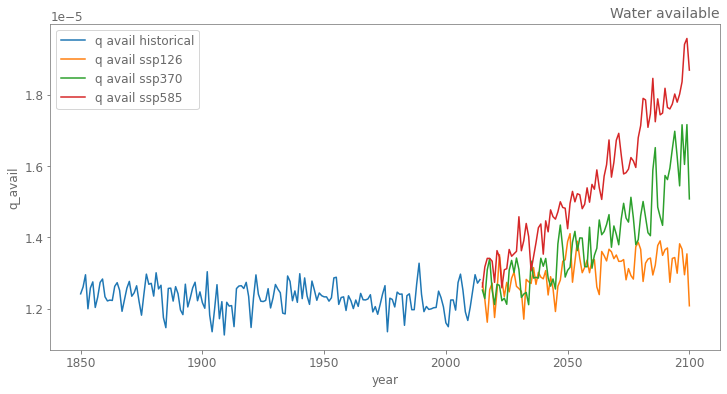

In [75]:
# per model and scenario
fig, ax = plt.subplots(figsize=(12,6))

# loop over models
for scenario in scenarios:

        #ds_median_ptotww.sel({'scenario':scenario}).plot(ax=ax, label = 'ptotww '+scenario)
        ds_median_q_avail.sel({'scenario':scenario}).plot(ax=ax, label = 'q avail '+scenario)
        
ax.legend()
ax.set_ylabel('q_avail')
ax.set_title('')
ax.set_title('Water available', loc='right');


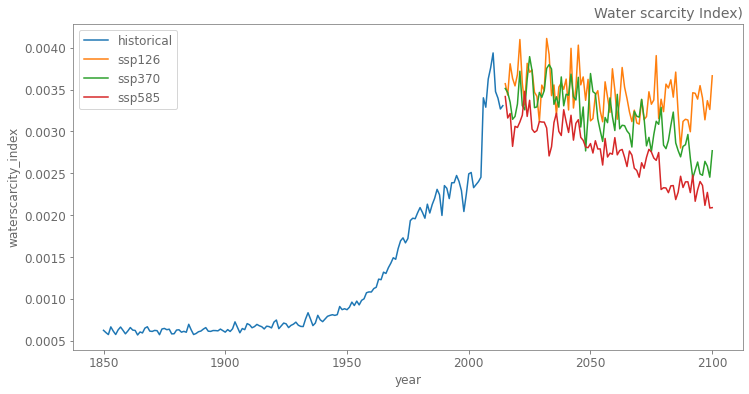

In [81]:
# per model and scenario
fig, ax = plt.subplots(figsize=(12,6))

# loop over models
for scenario in scenarios:

        ds_median.sel({'scenario':scenario}).plot(ax=ax, label = scenario)
ax.legend()
ax.set_ylabel('waterscarcity_index')
ax.set_title('')
ax.set_title('Water scarcity Index)', loc='right');
#ax.set_xlim([2000,2020])

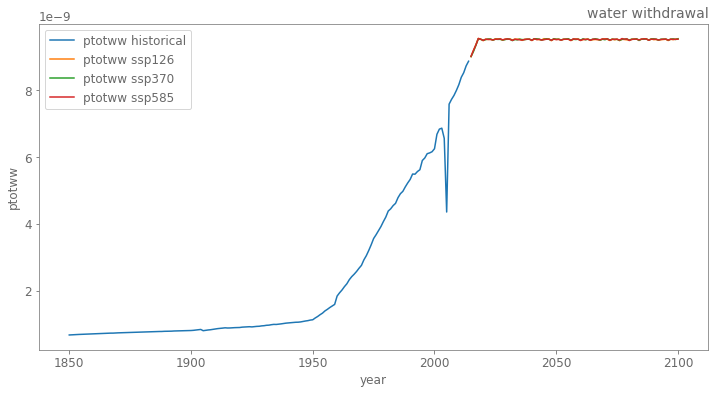

In [58]:
# per model and scenario
fig, ax = plt.subplots(figsize=(12,6))

# loop over models
for scenario in scenarios:

        ds_median_ptotww.sel({'scenario':scenario}).plot(ax=ax, label = 'ptotww '+scenario)
        #ds_median_q_avail.sel({'scenario':scenario}).plot(ax=ax, label = 'q avail '+scenario)
        
ax.legend()
ax.set_ylabel('ptotww')
ax.set_title('')
ax.set_title('water withdrawal', loc='right');


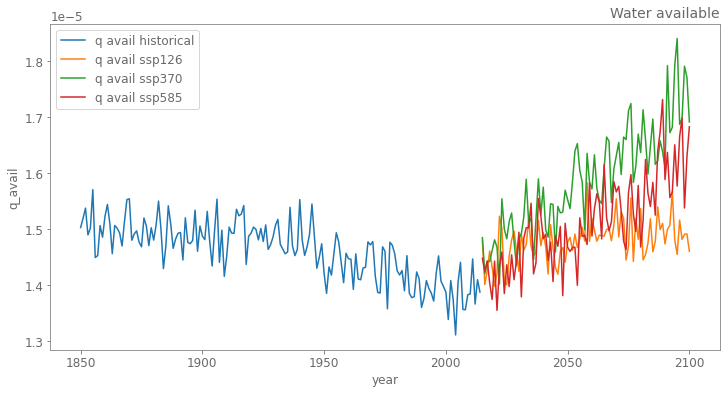

In [59]:
# per model and scenario
fig, ax = plt.subplots(figsize=(12,6))

# loop over models
for scenario in scenarios:

        #ds_median_ptotww.sel({'scenario':scenario}).plot(ax=ax, label = 'ptotww '+scenario)
        ds_median_q_avail.sel({'scenario':scenario}).plot(ax=ax, label = 'q avail '+scenario)
        
ax.legend()
ax.set_ylabel('q_avail')
ax.set_title('')
ax.set_title('Water available', loc='right');


### southern spain

In [85]:
# southern Spain

lat_sel = 37.75
lon_sel = -2.25


# USA Mid-west
lat_sel = 36.75
lon_sel = -118.75

# Middle East
lat_sel = 30.75
lon_sel = 39.25


ds_sel_wsindex = ds_waterscarcity_index['wsindex'].squeeze().sel({'lat':lat_sel,'lon':lon_sel})
ds_sel_ptotww = ds_ptotww['ptotww'].squeeze().sel({'lat':lat_sel,'lon':lon_sel})
ds_sel_q_avail = ds_qavail['q_avail'].squeeze().sel({'lat':lat_sel,'lon':lon_sel})

(-0.5, 100000.0)

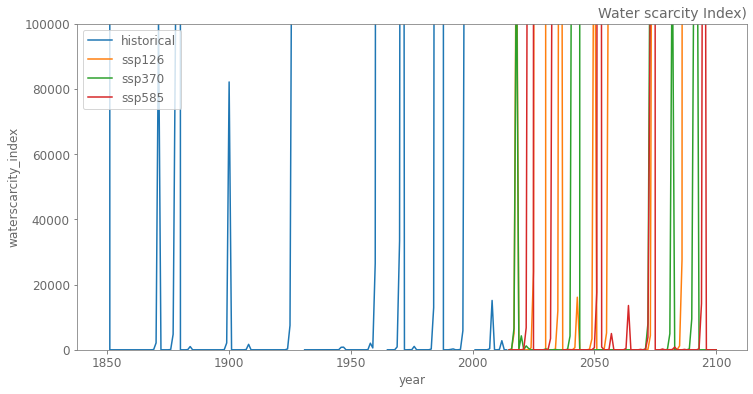

In [93]:
# per model and scenario
fig, ax = plt.subplots(figsize=(12,6))

# loop over models
for scenario in scenarios:

        ds_sel_wsindex.sel({'scenario':scenario}).plot(ax=ax, label = scenario)
ax.legend()
ax.set_ylabel('waterscarcity_index')
ax.set_title('')
ax.set_title('Water scarcity Index)', loc='right');
ax.set_ylim([-0.5,100000])

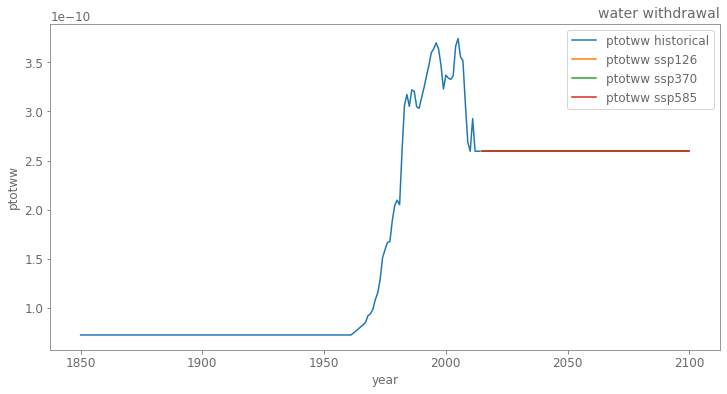

In [95]:
# per model and scenario
fig, ax = plt.subplots(figsize=(12,6))

# loop over models
for scenario in scenarios:

        ds_sel_ptotww.sel({'scenario':scenario}).plot(ax=ax, label = 'ptotww '+scenario)
        #ds_median_q_avail.sel({'scenario':scenario}).plot(ax=ax, label = 'q avail '+scenario)
        
ax.legend()
ax.set_ylabel('ptotww')
ax.set_title('')
ax.set_title('water withdrawal', loc='right');


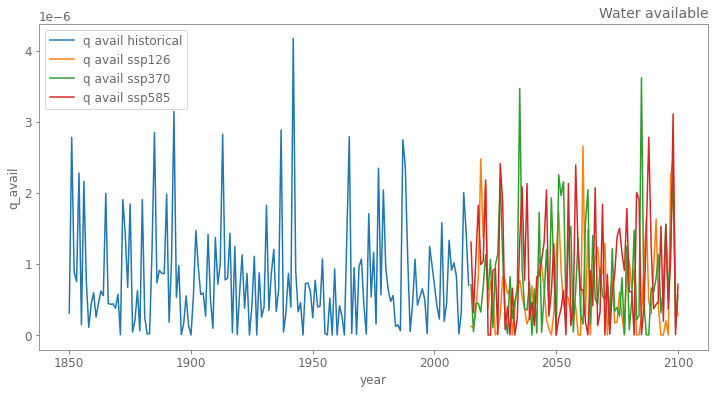

In [97]:
# per model and scenario
fig, ax = plt.subplots(figsize=(12,6))

# loop over models
for scenario in scenarios:

        #ds_median_ptotww.sel({'scenario':scenario}).plot(ax=ax, label = 'ptotww '+scenario)
        ds_sel_q_avail.sel({'scenario':scenario}).plot(ax=ax, label = 'q avail '+scenario)
        
ax.legend()
ax.set_ylabel('q_avail')
ax.set_title('')
ax.set_title('Water available', loc='right');


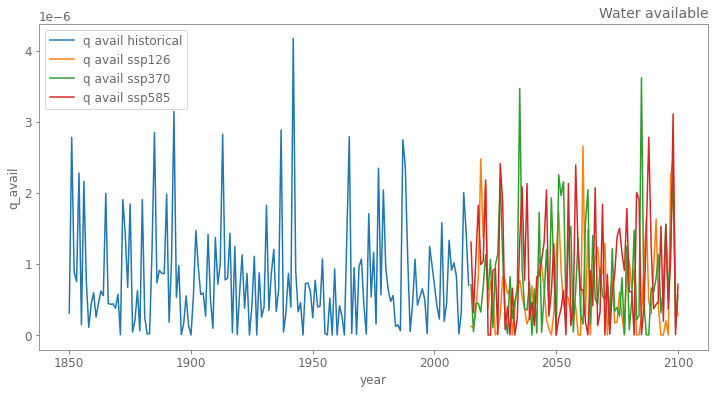

In [98]:
# per model and scenario
fig, ax = plt.subplots(figsize=(12,6))

# loop over models
for scenario in scenarios:

        #ds_median_ptotww.sel({'scenario':scenario}).plot(ax=ax, label = 'ptotww '+scenario)
        ds_sel_q_avail.sel({'scenario':scenario}).plot(ax=ax, label = 'q avail '+scenario)
        
ax.legend()
ax.set_ylabel('q_avail')
ax.set_title('')
ax.set_title('Water available', loc='right');


### Falkenmark